# Q-Learning vs. Double Q-Learning

In this following notebook, we show a comparison between the off-policy RL algorithms *Q-Learning* and *Double Q-Learning* using deep neural networks. We follow the algorithms' implementations from the Introduction to RL book by Sutton & Barto [1], while deviating from the original implementations only in our usage of neural networks instead of tabular q-functions. The whole point of *Double Q-Learning* is to eliminate the overestimation bias (also known as maximization bias) introduced in *Q-Learning*'s **max** operation over the values of the next greedy action. This maximum operation results in an overestimation of the greedy action's q-values, which causes suboptimal behavior. Following the words of Sutton & Barto "*a maximum over estimated values is used implicitly as an estimate of the maximum value, which can lead to a significant positive bias*"

To that end, *Double Q-Learning* is introduced, where two different q-functions are learned. Then, on each update, one q-function computes the next greedy action, while the other q-function estimates the action's value. That way, the overestimation bias is eliminated.

We compare two different update-rules for the *Double Q-Learning* algorithm, the original one (from the book)

$$
\begin{align}
    Q_1(S, A) &\leftarrow Q_1(S, A) + \alpha\left(R + \gamma Q_2\left(S', \text{argmax}_a Q_1(S', a)\right) - Q_1(S, A)\right),\\
    Q_2(S, A) &\leftarrow Q_2(S, A) + \alpha\left(R + \gamma Q_1\left(S', \text{argmax}_a Q_2(S', a)\right) - Q_2(S, A)\right),
\end{align}
$$

where one q-function computes the greedy action while the other estimates its value, to the following one

$$
\begin{align}
    Q_1(S, A) &\leftarrow Q_1(S, A) + \alpha\left(R + \gamma \text{min}_{i\in(1, 2)}Q_i\left(S', \text{argmax}_a Q_1(S', a)\right) - Q_1(S, A)\right),\\
    Q_2(S, A) &\leftarrow Q_2(S, A) + \alpha\left(R + \gamma \text{min}_{i\in(1, 2)}Q_i\left(S', \text{argmax}_a Q_2(S', a)\right) - Q_2(S, A)\right),
\end{align}
$$

where each q function chooses its greedy next action for the update, but the estimated value taken, is the minimum estimate between the two q functions. 

We use the *Acrobot-v1* environment illustrated below, borrowed from the [Acrobot Gymnasium webpage](https://gymnasium.farama.org/environments/classic_control/acrobot/)

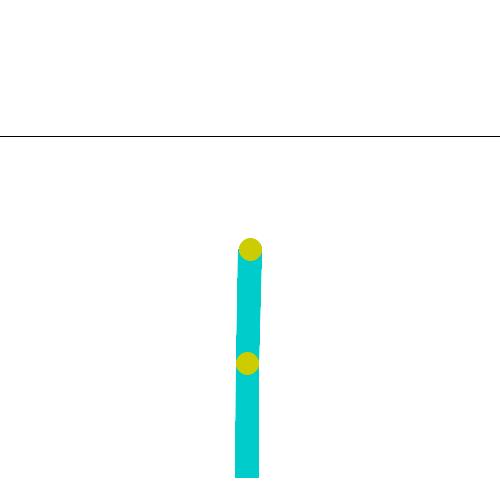

So, let's begin.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

In [2]:
# define a dictionary for saving results
results_data_dict = {}

Adding a few utility functions for plotting.

In [3]:
def plot_results(avg_scores, std_scores, name=None):
    # set title name
    if name is not None:
        title_name = f"Score averaged over different experiments ({name})"
    else:
        title_name = f"Score averaged over different experiments"
    
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    
    ax[0].set_title(title_name)
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms' averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)

        upper_std_scores = avg_avg_scores + std_avg_scores
        lower_std_scores = avg_avg_scores - std_avg_scores
        x = range(1, n_episodes + 1)


        ax.plot(x, avg_avg_scores, label=f'{name} agent')
        ax.fill_between(x, upper_std_scores, lower_std_scores, 
                        where=(upper_std_scores > lower_std_scores), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()

# Q-Learning

Below is the complete Q-Learning algorithm for the tabular case. We will use a neural network instead of a tabular Q-function.

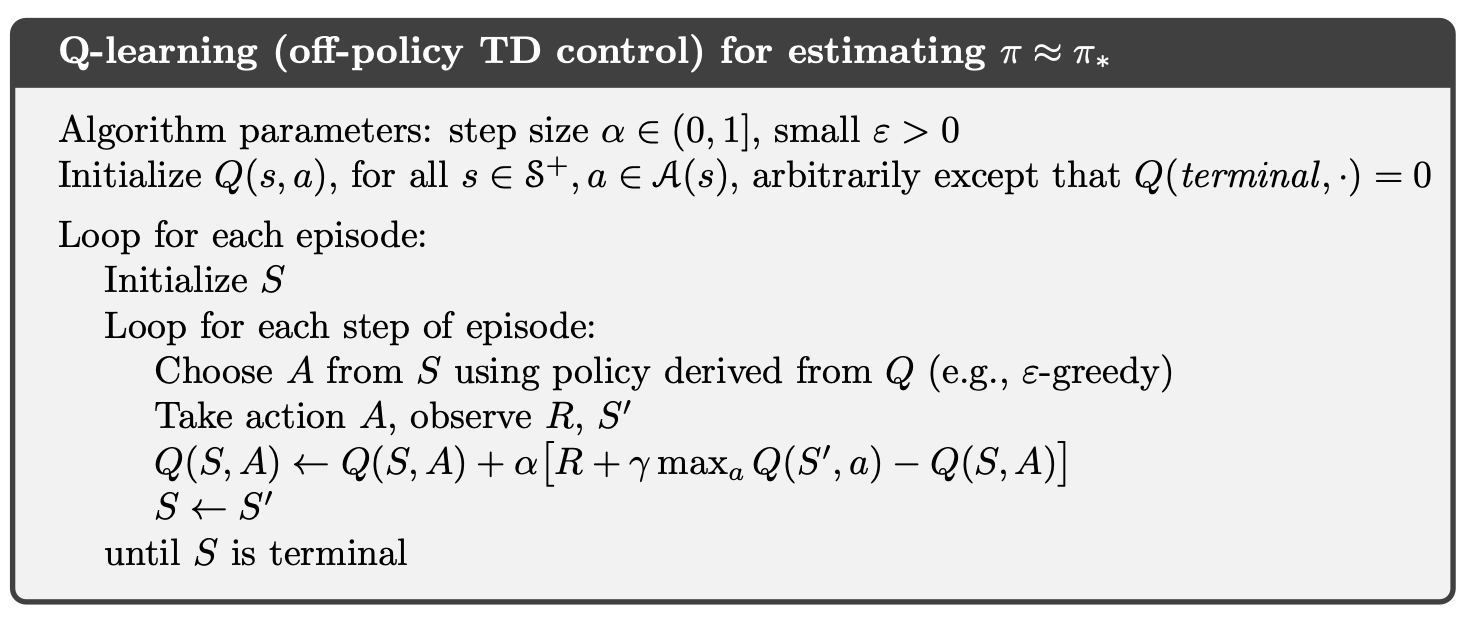

We begin with writing the neural network for the Q-function, which is just a Multi-Layer Perceptron (MLP) with three layers.  

In [4]:
class QNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.output_layer = nn.Linear(in_features=256, out_features=action_dim)
    
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

## Adding a Replay Buffer

Next, we add a replay buffer to the Q-Learning agent. Although training with PyTorch, which uses Tensor objects, it is simpler and more convenient to code the replay-buffer using Numpy.

In [5]:
class ReplayBuffer:
    def __init__(self, memory_size, observation_dim):
        self.observation_dim = observation_dim
        self.memory_size = memory_size
        self.ptr = 0
        self.is_full = False
        
        self.observations = None
        self.actions = None
        self.rewards = None
        self.next_observations = None
        self.terminates = None
        
    def reset(self):
        print("reset buffer...")
        self.observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.actions = np.zeros((self.memory_size, 1), dtype=int)
        self.rewards = np.zeros((self.memory_size, 1), dtype=np.float32)
        self.next_observations = np.zeros((self.memory_size, self.observation_dim), dtype=np.float32)
        self.terminates = np.zeros((self.memory_size, 1), dtype=bool)
        self.ptr = 0
    
    def store_transition(self, observation, action, reward, next_observation, terminated):
        self.observations[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_observations[self.ptr] = next_observation
        self.terminates[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.memory_size
        if self.ptr==0 and not self.is_full:
            self.is_full = True
            print("buffer is full...")
    
    def load_transition(self, batch_size=1):
        upper = self.memory_size if self.is_full else self.ptr
        samples = np.random.choice(upper, size=batch_size)
        return (self.observations[samples], self.actions[samples], self.rewards[samples], 
                self.next_observations[samples], self.terminates[samples])
    

Then, we write the Q-Learning agent class, utilizing an $\epsilon$-greedy policy scheme.

In [6]:
class QLearningAgent:
    def __init__(self, observation_dim, action_dim, n_actions, 
                 learning_rate, gamma, epsilon, epsilon_dec, epsilon_min, 
                 memory_size):
        super(QLearningAgent, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.memory_size = memory_size
        self.learning_steps = 0
        
        # initialize a q network
        self.q = QNetwork(observation_dim, n_actions, learning_rate)
        
        # initialize a replay buffer
        self.replay_buffer = ReplayBuffer(memory_size, observation_dim)
        self.replay_buffer.reset()
        
    def choose_action(self, observation, evaluate=False):
        observation = T.from_numpy(observation).float().to(self.q.device)
        if evaluate:
            q_values = self.q(observation)
            action = T.argmax(q_values).item()
        else:
            if np.random.rand() < self.epsilon:
                action = np.random.randint(low=0, high=self.n_actions, size=1)[0]
            else:
                q_values = self.q(observation)
                action = T.argmax(q_values).item()
        return action
                
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
        
    def store_transition(self, observation, action, reward, next_observation, terminated):
        self.replay_buffer.store_transition(observation, action, reward, next_observation, terminated)
        
    def load_batch(self, batch_size=1):
        return self.replay_buffer.load_transition(batch_size) 
        
    
    def learn(self, batch_size=1):
        self.learning_steps += 1
        if self.learning_steps <= batch_size:
            return
        
        # load batch from buffer
        observation, action, reward, next_observation, terminated = self.load_batch(batch_size)
        
        
        # send the transition to the device
        observation = T.from_numpy(observation).float().to(self.q.device)
        action = T.from_numpy(action).int().view(-1).to(self.q.device)
        reward = T.tensor(reward).float().view(-1).to(self.q.device)
        next_observation = T.from_numpy(next_observation).float().to(self.q.device)
        terminated = T.from_numpy(terminated).bool().view(-1).to(self.q.device)
        
        # compute the q_values
        indices = T.arange(batch_size)
        q_value = self.q(observation)[indices, action]
        next_q_value = T.max(self.q(next_observation), dim=1)[0] # take only the zero element which are the max values
        next_q_value[terminated] = 0.0  # set terminal state values to zero by hand
        
        # compute the target
        target = (reward + self.gamma * next_q_value).to(self.q.device)
        
        # compute the loss and backpropagate
        self.q.optimizer.zero_grad()
        q_loss = F.mse_loss(q_value, target)
        q_loss.backward()
        self.q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()
    

Finally, we can run a few experiments. 

In [7]:
env = gym.make('Acrobot-v1')
scores = []
avg_scores = []
std_scores = []
epsilons = []

N_EXPERIMENTS = 5
N_EPISODES = 600
MAX_STEPS = 600
GAMMA = 0.99
LR = 5e-5
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = 1
N_ACTIONS = env.action_space.n
MEMORY_SIZE = 100000
BATCH_SIZE = 8

# run the experiments
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    epsilons.append([])
    
    # init the agent
    agent = QLearningAgent(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, n_actions=N_ACTIONS, 
                           learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_dec=EPSILON_DEC, 
                           epsilon_min=EPSILON_MIN, memory_size=MEMORY_SIZE)
    # run the episodes for each experiment
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        score = 0
        step = 0
        done = False

        while not done:
            step += 1
            epsilons[ex_i].append(agent.epsilon)
            action = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # store transition
            agent.store_transition(observation, action, reward, next_observation, terminated)
            
            # train the agent
            agent.learn(batch_size=BATCH_SIZE)
            
            # set next states to current states
            observation = next_observation
            
            # check for end of episode
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f}' + \
              f'| Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

reset buffer...
| Experiment:    1 | Episode:    0 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    1 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    2 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    3 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    4 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    5 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    6 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    7 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   12 | Score: -500.000| Avg score: -500.00

| Experiment:    1 | Episode:  108 | Score: -500.000| Avg score: -203.210 |
| Experiment:    1 | Episode:  109 | Score: -155.000| Avg score: -199.760 |
| Experiment:    1 | Episode:  110 | Score: -162.000| Avg score: -196.380 |
| Experiment:    1 | Episode:  111 | Score: -144.000| Avg score: -192.820 |
| Experiment:    1 | Episode:  112 | Score: -175.000| Avg score: -189.570 |
| Experiment:    1 | Episode:  113 | Score: -149.000| Avg score: -186.060 |
| Experiment:    1 | Episode:  114 | Score: -195.000| Avg score: -183.010 |
| Experiment:    1 | Episode:  115 | Score: -159.000| Avg score: -179.600 |
| Experiment:    1 | Episode:  116 | Score: -180.000| Avg score: -176.400 |
| Experiment:    1 | Episode:  117 | Score: -190.000| Avg score: -173.300 |
| Experiment:    1 | Episode:  118 | Score: -473.000| Avg score: -173.030 |
| Experiment:    1 | Episode:  119 | Score: -500.000| Avg score: -176.400 |
| Experiment:    1 | Episode:  120 | Score: -500.000| Avg score: -176.400 |
| Experiment

| Experiment:    1 | Episode:  219 | Score: -95.000| Avg score: -322.130 |
| Experiment:    1 | Episode:  220 | Score: -133.000| Avg score: -318.460 |
| Experiment:    1 | Episode:  221 | Score: -123.000| Avg score: -314.690 |
| Experiment:    1 | Episode:  222 | Score: -94.000| Avg score: -310.630 |
| Experiment:    1 | Episode:  223 | Score: -105.000| Avg score: -306.680 |
| Experiment:    1 | Episode:  224 | Score: -76.000| Avg score: -302.440 |
| Experiment:    1 | Episode:  225 | Score: -77.000| Avg score: -298.210 |
| Experiment:    1 | Episode:  226 | Score: -126.000| Avg score: -294.470 |
| Experiment:    1 | Episode:  227 | Score: -110.000| Avg score: -290.570 |
| Experiment:    1 | Episode:  228 | Score: -113.000| Avg score: -286.700 |
| Experiment:    1 | Episode:  229 | Score: -106.000| Avg score: -282.760 |
| Experiment:    1 | Episode:  230 | Score: -77.000| Avg score: -278.530 |
| Experiment:    1 | Episode:  231 | Score: -129.000| Avg score: -274.820 |
| Experiment:    

| Experiment:    1 | Episode:  330 | Score: -183.000| Avg score: -92.470 |
| Experiment:    1 | Episode:  331 | Score: -81.000| Avg score: -91.990 |
| Experiment:    1 | Episode:  332 | Score: -83.000| Avg score: -91.550 |
| Experiment:    1 | Episode:  333 | Score: -63.000| Avg score: -91.410 |
| Experiment:    1 | Episode:  334 | Score: -94.000| Avg score: -91.340 |
| Experiment:    1 | Episode:  335 | Score: -83.000| Avg score: -91.460 |
| Experiment:    1 | Episode:  336 | Score: -120.000| Avg score: -91.770 |
| Experiment:    1 | Episode:  337 | Score: -94.000| Avg score: -91.950 |
| Experiment:    1 | Episode:  338 | Score: -79.000| Avg score: -91.660 |
| Experiment:    1 | Episode:  339 | Score: -84.000| Avg score: -91.470 |
| Experiment:    1 | Episode:  340 | Score: -62.000| Avg score: -91.050 |
| Experiment:    1 | Episode:  341 | Score: -72.000| Avg score: -90.610 |
| Experiment:    1 | Episode:  342 | Score: -70.000| Avg score: -90.200 |
| Experiment:    1 | Episode:  343 |

| Experiment:    1 | Episode:  440 | Score: -500.000| Avg score: -149.080 |
| Experiment:    1 | Episode:  441 | Score: -500.000| Avg score: -153.360 |
| Experiment:    1 | Episode:  442 | Score: -500.000| Avg score: -157.660 |
| Experiment:    1 | Episode:  443 | Score: -500.000| Avg score: -161.580 |
| Experiment:    1 | Episode:  444 | Score: -371.000| Avg score: -164.220 |
| Experiment:    1 | Episode:  445 | Score: -420.000| Avg score: -167.590 |
| Experiment:    1 | Episode:  446 | Score: -500.000| Avg score: -171.440 |
| Experiment:    1 | Episode:  447 | Score: -500.000| Avg score: -175.510 |
| Experiment:    1 | Episode:  448 | Score: -453.000| Avg score: -179.200 |
| Experiment:    1 | Episode:  449 | Score: -500.000| Avg score: -183.240 |
| Experiment:    1 | Episode:  450 | Score: -500.000| Avg score: -187.600 |
| Experiment:    1 | Episode:  451 | Score: -500.000| Avg score: -191.780 |
| Experiment:    1 | Episode:  452 | Score: -500.000| Avg score: -195.920 |
| Experiment

| Experiment:    1 | Episode:  549 | Score: -150.000| Avg score: -220.220 |
| Experiment:    1 | Episode:  550 | Score: -97.000| Avg score: -216.190 |
| Experiment:    1 | Episode:  551 | Score: -86.000| Avg score: -212.050 |
| Experiment:    1 | Episode:  552 | Score: -87.000| Avg score: -207.920 |
| Experiment:    1 | Episode:  553 | Score: -87.000| Avg score: -203.790 |
| Experiment:    1 | Episode:  554 | Score: -78.000| Avg score: -199.570 |
| Experiment:    1 | Episode:  555 | Score: -88.000| Avg score: -195.450 |
| Experiment:    1 | Episode:  556 | Score: -117.000| Avg score: -191.620 |
| Experiment:    1 | Episode:  557 | Score: -125.000| Avg score: -187.870 |
| Experiment:    1 | Episode:  558 | Score: -86.000| Avg score: -183.730 |
| Experiment:    1 | Episode:  559 | Score: -125.000| Avg score: -179.980 |
| Experiment:    1 | Episode:  560 | Score: -98.000| Avg score: -175.960 |
| Experiment:    1 | Episode:  561 | Score: -105.000| Avg score: -172.010 |
| Experiment:    1 |

| Experiment:    2 | Episode:   59 | Score: -134.000| Avg score: -383.320 |
| Experiment:    2 | Episode:   60 | Score: -216.000| Avg score: -380.570 |
| Experiment:    2 | Episode:   61 | Score: -178.000| Avg score: -377.310 |
| Experiment:    2 | Episode:   62 | Score: -146.000| Avg score: -373.630 |
| Experiment:    2 | Episode:   63 | Score: -125.000| Avg score: -369.750 |
| Experiment:    2 | Episode:   64 | Score: -166.000| Avg score: -366.620 |
| Experiment:    2 | Episode:   65 | Score: -145.000| Avg score: -363.260 |
| Experiment:    2 | Episode:   66 | Score: -133.000| Avg score: -359.820 |
| Experiment:    2 | Episode:   67 | Score: -151.000| Avg score: -356.750 |
| Experiment:    2 | Episode:   68 | Score: -120.000| Avg score: -353.320 |
| Experiment:    2 | Episode:   69 | Score: -164.000| Avg score: -350.610 |
| Experiment:    2 | Episode:   70 | Score: -180.000| Avg score: -348.210 |
| Experiment:    2 | Episode:   71 | Score: -381.000| Avg score: -348.670 |
| Experiment

| Experiment:    2 | Episode:  168 | Score: -313.000| Avg score: -135.250 |
| Experiment:    2 | Episode:  169 | Score: -500.000| Avg score: -138.610 |
| Experiment:    2 | Episode:  170 | Score: -500.000| Avg score: -141.810 |
| Experiment:    2 | Episode:  171 | Score: -500.000| Avg score: -143.000 |
| Experiment:    2 | Episode:  172 | Score: -500.000| Avg score: -146.750 |
| Experiment:    2 | Episode:  173 | Score: -500.000| Avg score: -150.240 |
| Experiment:    2 | Episode:  174 | Score: -500.000| Avg score: -153.800 |
| Experiment:    2 | Episode:  175 | Score: -500.000| Avg score: -156.890 |
| Experiment:    2 | Episode:  176 | Score: -500.000| Avg score: -160.650 |
| Experiment:    2 | Episode:  177 | Score: -500.000| Avg score: -164.000 |
| Experiment:    2 | Episode:  178 | Score: -500.000| Avg score: -167.680 |
| Experiment:    2 | Episode:  179 | Score: -500.000| Avg score: -171.100 |
| Experiment:    2 | Episode:  180 | Score: -380.000| Avg score: -173.580 |
| Experiment

| Experiment:    2 | Episode:  277 | Score: -110.000| Avg score: -365.820 |
| Experiment:    2 | Episode:  278 | Score: -102.000| Avg score: -361.840 |
| Experiment:    2 | Episode:  279 | Score: -202.000| Avg score: -358.860 |
| Experiment:    2 | Episode:  280 | Score: -118.000| Avg score: -356.240 |
| Experiment:    2 | Episode:  281 | Score: -116.000| Avg score: -354.940 |
| Experiment:    2 | Episode:  282 | Score: -226.000| Avg score: -355.160 |
| Experiment:    2 | Episode:  283 | Score: -136.000| Avg score: -355.450 |
| Experiment:    2 | Episode:  284 | Score: -72.000| Avg score: -354.610 |
| Experiment:    2 | Episode:  285 | Score: -142.000| Avg score: -351.030 |
| Experiment:    2 | Episode:  286 | Score: -100.000| Avg score: -350.270 |
| Experiment:    2 | Episode:  287 | Score: -79.000| Avg score: -346.490 |
| Experiment:    2 | Episode:  288 | Score: -117.000| Avg score: -345.090 |
| Experiment:    2 | Episode:  289 | Score: -189.000| Avg score: -344.670 |
| Experiment: 

| Experiment:    2 | Episode:  386 | Score: -166.000| Avg score: -95.360 |
| Experiment:    2 | Episode:  387 | Score: -85.000| Avg score: -95.420 |
| Experiment:    2 | Episode:  388 | Score: -75.000| Avg score: -95.000 |
| Experiment:    2 | Episode:  389 | Score: -89.000| Avg score: -94.000 |
| Experiment:    2 | Episode:  390 | Score: -90.000| Avg score: -93.880 |
| Experiment:    2 | Episode:  391 | Score: -89.000| Avg score: -93.560 |
| Experiment:    2 | Episode:  392 | Score: -70.000| Avg score: -93.340 |
| Experiment:    2 | Episode:  393 | Score: -103.000| Avg score: -93.120 |
| Experiment:    2 | Episode:  394 | Score: -82.000| Avg score: -92.990 |
| Experiment:    2 | Episode:  395 | Score: -89.000| Avg score: -92.140 |
| Experiment:    2 | Episode:  396 | Score: -70.000| Avg score: -92.060 |
| Experiment:    2 | Episode:  397 | Score: -84.000| Avg score: -92.060 |
| Experiment:    2 | Episode:  398 | Score: -83.000| Avg score: -91.960 |
| Experiment:    2 | Episode:  399 |

| Experiment:    2 | Episode:  498 | Score: -100.000| Avg score: -85.890 |
| Experiment:    2 | Episode:  499 | Score: -76.000| Avg score: -85.900 |
| Experiment:    2 | Episode:  500 | Score: -114.000| Avg score: -86.120 |
buffer is full...
| Experiment:    2 | Episode:  501 | Score: -76.000| Avg score: -85.560 |
| Experiment:    2 | Episode:  502 | Score: -71.000| Avg score: -85.200 |
| Experiment:    2 | Episode:  503 | Score: -87.000| Avg score: -85.250 |
| Experiment:    2 | Episode:  504 | Score: -112.000| Avg score: -85.660 |
| Experiment:    2 | Episode:  505 | Score: -73.000| Avg score: -85.600 |
| Experiment:    2 | Episode:  506 | Score: -63.000| Avg score: -85.370 |
| Experiment:    2 | Episode:  507 | Score: -84.000| Avg score: -85.460 |
| Experiment:    2 | Episode:  508 | Score: -87.000| Avg score: -85.290 |
| Experiment:    2 | Episode:  509 | Score: -83.000| Avg score: -85.420 |
| Experiment:    2 | Episode:  510 | Score: -74.000| Avg score: -85.340 |
| Experiment:    

| Experiment:    3 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   12 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   13 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   14 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   15 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   16 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   17 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   18 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   19 | Score: -384.000| Avg score: -494.200 |
| Experiment:    3 | Episode:   20 | Score: -189.000| Avg score: -479.670 |
| Experiment

| Experiment:    3 | Episode:  117 | Score: -103.000| Avg score: -94.310 |
| Experiment:    3 | Episode:  118 | Score: -84.000| Avg score: -90.150 |
| Experiment:    3 | Episode:  119 | Score: -78.000| Avg score: -87.090 |
| Experiment:    3 | Episode:  120 | Score: -97.000| Avg score: -86.170 |
| Experiment:    3 | Episode:  121 | Score: -78.000| Avg score: -86.170 |
| Experiment:    3 | Episode:  122 | Score: -82.000| Avg score: -86.280 |
| Experiment:    3 | Episode:  123 | Score: -105.000| Avg score: -86.650 |
| Experiment:    3 | Episode:  124 | Score: -79.000| Avg score: -86.660 |
| Experiment:    3 | Episode:  125 | Score: -82.000| Avg score: -86.770 |
| Experiment:    3 | Episode:  126 | Score: -80.000| Avg score: -86.780 |
| Experiment:    3 | Episode:  127 | Score: -80.000| Avg score: -86.680 |
| Experiment:    3 | Episode:  128 | Score: -74.000| Avg score: -86.640 |
| Experiment:    3 | Episode:  129 | Score: -83.000| Avg score: -86.710 |
| Experiment:    3 | Episode:  130 |

| Experiment:    3 | Episode:  226 | Score: -215.000| Avg score: -336.960 |
| Experiment:    3 | Episode:  227 | Score: -129.000| Avg score: -337.450 |
| Experiment:    3 | Episode:  228 | Score: -116.000| Avg score: -337.870 |
| Experiment:    3 | Episode:  229 | Score: -152.000| Avg score: -338.560 |
| Experiment:    3 | Episode:  230 | Score: -108.000| Avg score: -337.740 |
| Experiment:    3 | Episode:  231 | Score: -118.000| Avg score: -338.120 |
| Experiment:    3 | Episode:  232 | Score: -152.000| Avg score: -338.860 |
| Experiment:    3 | Episode:  233 | Score: -112.000| Avg score: -339.020 |
| Experiment:    3 | Episode:  234 | Score: -124.000| Avg score: -339.510 |
| Experiment:    3 | Episode:  235 | Score: -107.000| Avg score: -339.510 |
| Experiment:    3 | Episode:  236 | Score: -101.000| Avg score: -339.780 |
| Experiment:    3 | Episode:  237 | Score: -109.000| Avg score: -340.080 |
| Experiment:    3 | Episode:  238 | Score: -96.000| Avg score: -340.180 |
| Experiment:

| Experiment:    3 | Episode:  337 | Score: -93.000| Avg score: -108.510 |
| Experiment:    3 | Episode:  338 | Score: -126.000| Avg score: -108.810 |
| Experiment:    3 | Episode:  339 | Score: -71.000| Avg score: -108.680 |
| Experiment:    3 | Episode:  340 | Score: -106.000| Avg score: -108.680 |
| Experiment:    3 | Episode:  341 | Score: -108.000| Avg score: -108.530 |
| Experiment:    3 | Episode:  342 | Score: -127.000| Avg score: -108.430 |
| Experiment:    3 | Episode:  343 | Score: -109.000| Avg score: -108.680 |
| Experiment:    3 | Episode:  344 | Score: -71.000| Avg score: -108.540 |
| Experiment:    3 | Episode:  345 | Score: -122.000| Avg score: -108.820 |
| Experiment:    3 | Episode:  346 | Score: -195.000| Avg score: -109.360 |
| Experiment:    3 | Episode:  347 | Score: -100.000| Avg score: -109.390 |
| Experiment:    3 | Episode:  348 | Score: -191.000| Avg score: -110.460 |
| Experiment:    3 | Episode:  349 | Score: -112.000| Avg score: -110.450 |
| Experiment:  

| Experiment:    3 | Episode:  445 | Score: -500.000| Avg score: -272.600 |
| Experiment:    3 | Episode:  446 | Score: -80.000| Avg score: -271.450 |
| Experiment:    3 | Episode:  447 | Score: -90.000| Avg score: -271.350 |
| Experiment:    3 | Episode:  448 | Score: -70.000| Avg score: -270.140 |
| Experiment:    3 | Episode:  449 | Score: -120.000| Avg score: -270.220 |
| Experiment:    3 | Episode:  450 | Score: -113.000| Avg score: -268.410 |
| Experiment:    3 | Episode:  451 | Score: -109.000| Avg score: -268.500 |
| Experiment:    3 | Episode:  452 | Score: -78.000| Avg score: -267.780 |
| Experiment:    3 | Episode:  453 | Score: -87.000| Avg score: -267.580 |
| Experiment:    3 | Episode:  454 | Score: -110.000| Avg score: -267.210 |
| Experiment:    3 | Episode:  455 | Score: -107.000| Avg score: -267.180 |
| Experiment:    3 | Episode:  456 | Score: -174.000| Avg score: -266.990 |
| Experiment:    3 | Episode:  457 | Score: -125.000| Avg score: -266.290 |
| Experiment:    

| Experiment:    3 | Episode:  555 | Score: -113.000| Avg score: -105.250 |
| Experiment:    3 | Episode:  556 | Score: -70.000| Avg score: -104.210 |
| Experiment:    3 | Episode:  557 | Score: -87.000| Avg score: -103.830 |
| Experiment:    3 | Episode:  558 | Score: -93.000| Avg score: -103.970 |
| Experiment:    3 | Episode:  559 | Score: -151.000| Avg score: -103.950 |
| Experiment:    3 | Episode:  560 | Score: -81.000| Avg score: -103.580 |
| Experiment:    3 | Episode:  561 | Score: -92.000| Avg score: -103.460 |
| Experiment:    3 | Episode:  562 | Score: -96.000| Avg score: -103.360 |
| Experiment:    3 | Episode:  563 | Score: -86.000| Avg score: -103.510 |
| Experiment:    3 | Episode:  564 | Score: -63.000| Avg score: -103.360 |
| Experiment:    3 | Episode:  565 | Score: -85.000| Avg score: -102.600 |
| Experiment:    3 | Episode:  566 | Score: -125.000| Avg score: -101.320 |
| Experiment:    3 | Episode:  567 | Score: -84.000| Avg score: -101.240 |
| Experiment:    3 | E

| Experiment:    4 | Episode:   65 | Score: -101.000| Avg score: -348.140 |
| Experiment:    4 | Episode:   66 | Score: -113.000| Avg score: -344.630 |
| Experiment:    4 | Episode:   67 | Score: -82.000| Avg score: -340.760 |
| Experiment:    4 | Episode:   68 | Score: -62.000| Avg score: -336.720 |
| Experiment:    4 | Episode:   69 | Score: -105.000| Avg score: -333.410 |
| Experiment:    4 | Episode:   70 | Score: -88.000| Avg score: -329.960 |
| Experiment:    4 | Episode:   71 | Score: -80.000| Avg score: -326.490 |
| Experiment:    4 | Episode:   72 | Score: -106.000| Avg score: -323.470 |
| Experiment:    4 | Episode:   73 | Score: -93.000| Avg score: -320.350 |
| Experiment:    4 | Episode:   74 | Score: -102.000| Avg score: -317.440 |
| Experiment:    4 | Episode:   75 | Score: -105.000| Avg score: -314.640 |
| Experiment:    4 | Episode:   76 | Score: -111.000| Avg score: -312.000 |
| Experiment:    4 | Episode:   77 | Score: -99.000| Avg score: -309.270 |
| Experiment:    4

| Experiment:    4 | Episode:  174 | Score: -94.000| Avg score: -104.660 |
| Experiment:    4 | Episode:  175 | Score: -122.000| Avg score: -104.830 |
| Experiment:    4 | Episode:  176 | Score: -91.000| Avg score: -104.630 |
| Experiment:    4 | Episode:  177 | Score: -93.000| Avg score: -104.570 |
| Experiment:    4 | Episode:  178 | Score: -125.000| Avg score: -104.790 |
| Experiment:    4 | Episode:  179 | Score: -120.000| Avg score: -104.980 |
| Experiment:    4 | Episode:  180 | Score: -106.000| Avg score: -105.110 |
| Experiment:    4 | Episode:  181 | Score: -128.000| Avg score: -105.380 |
| Experiment:    4 | Episode:  182 | Score: -198.000| Avg score: -106.480 |
| Experiment:    4 | Episode:  183 | Score: -156.000| Avg score: -107.160 |
| Experiment:    4 | Episode:  184 | Score: -200.000| Avg score: -108.150 |
| Experiment:    4 | Episode:  185 | Score: -222.000| Avg score: -109.480 |
| Experiment:    4 | Episode:  186 | Score: -378.000| Avg score: -112.170 |
| Experiment:  

| Experiment:    4 | Episode:  283 | Score: -254.000| Avg score: -371.520 |
| Experiment:    4 | Episode:  284 | Score: -229.000| Avg score: -371.810 |
| Experiment:    4 | Episode:  285 | Score: -123.000| Avg score: -370.820 |
| Experiment:    4 | Episode:  286 | Score: -118.000| Avg score: -368.220 |
| Experiment:    4 | Episode:  287 | Score: -111.000| Avg score: -366.350 |
| Experiment:    4 | Episode:  288 | Score: -90.000| Avg score: -362.250 |
| Experiment:    4 | Episode:  289 | Score: -182.000| Avg score: -359.070 |
| Experiment:    4 | Episode:  290 | Score: -439.000| Avg score: -358.460 |
| Experiment:    4 | Episode:  291 | Score: -314.000| Avg score: -356.600 |
| Experiment:    4 | Episode:  292 | Score: -116.000| Avg score: -352.760 |
| Experiment:    4 | Episode:  293 | Score: -113.000| Avg score: -348.890 |
| Experiment:    4 | Episode:  294 | Score: -182.000| Avg score: -347.190 |
| Experiment:    4 | Episode:  295 | Score: -145.000| Avg score: -344.450 |
| Experiment:

| Experiment:    4 | Episode:  394 | Score: -171.000| Avg score: -154.660 |
| Experiment:    4 | Episode:  395 | Score: -72.000| Avg score: -153.930 |
| Experiment:    4 | Episode:  396 | Score: -120.000| Avg score: -153.210 |
| Experiment:    4 | Episode:  397 | Score: -77.000| Avg score: -152.520 |
| Experiment:    4 | Episode:  398 | Score: -69.000| Avg score: -151.980 |
| Experiment:    4 | Episode:  399 | Score: -70.000| Avg score: -151.640 |
| Experiment:    4 | Episode:  400 | Score: -105.000| Avg score: -151.010 |
| Experiment:    4 | Episode:  401 | Score: -71.000| Avg score: -150.070 |
| Experiment:    4 | Episode:  402 | Score: -76.000| Avg score: -149.340 |
| Experiment:    4 | Episode:  403 | Score: -81.000| Avg score: -149.110 |
| Experiment:    4 | Episode:  404 | Score: -87.000| Avg score: -148.880 |
| Experiment:    4 | Episode:  405 | Score: -99.000| Avg score: -148.880 |
| Experiment:    4 | Episode:  406 | Score: -69.000| Avg score: -148.060 |
| Experiment:    4 | E

buffer is full...
| Experiment:    4 | Episode:  504 | Score: -79.000| Avg score: -87.250 |
| Experiment:    4 | Episode:  505 | Score: -85.000| Avg score: -87.110 |
| Experiment:    4 | Episode:  506 | Score: -83.000| Avg score: -87.250 |
| Experiment:    4 | Episode:  507 | Score: -72.000| Avg score: -87.340 |
| Experiment:    4 | Episode:  508 | Score: -81.000| Avg score: -87.170 |
| Experiment:    4 | Episode:  509 | Score: -88.000| Avg score: -87.110 |
| Experiment:    4 | Episode:  510 | Score: -76.000| Avg score: -87.010 |
| Experiment:    4 | Episode:  511 | Score: -71.000| Avg score: -87.030 |
| Experiment:    4 | Episode:  512 | Score: -114.000| Avg score: -87.380 |
| Experiment:    4 | Episode:  513 | Score: -62.000| Avg score: -87.220 |
| Experiment:    4 | Episode:  514 | Score: -92.000| Avg score: -87.360 |
| Experiment:    4 | Episode:  515 | Score: -70.000| Avg score: -86.640 |
| Experiment:    4 | Episode:  516 | Score: -99.000| Avg score: -86.930 |
| Experiment:    4 

| Experiment:    5 | Episode:   14 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   15 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   16 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   17 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   18 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   19 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   20 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   21 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   22 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   23 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   24 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   25 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   26 | Score: -208.000| Avg score: -489.190 |
| Experiment

| Experiment:    5 | Episode:  123 | Score: -225.000| Avg score: -136.650 |
| Experiment:    5 | Episode:  124 | Score: -146.000| Avg score: -133.110 |
| Experiment:    5 | Episode:  125 | Score: -153.000| Avg score: -129.640 |
| Experiment:    5 | Episode:  126 | Score: -152.000| Avg score: -129.080 |
| Experiment:    5 | Episode:  127 | Score: -167.000| Avg score: -129.790 |
| Experiment:    5 | Episode:  128 | Score: -173.000| Avg score: -130.750 |
| Experiment:    5 | Episode:  129 | Score: -147.000| Avg score: -131.310 |
| Experiment:    5 | Episode:  130 | Score: -137.000| Avg score: -131.920 |
| Experiment:    5 | Episode:  131 | Score: -145.000| Avg score: -132.580 |
| Experiment:    5 | Episode:  132 | Score: -157.000| Avg score: -133.360 |
| Experiment:    5 | Episode:  133 | Score: -140.000| Avg score: -133.980 |
| Experiment:    5 | Episode:  134 | Score: -139.000| Avg score: -134.430 |
| Experiment:    5 | Episode:  135 | Score: -159.000| Avg score: -135.260 |
| Experiment

| Experiment:    5 | Episode:  231 | Score: -500.000| Avg score: -237.400 |
| Experiment:    5 | Episode:  232 | Score: -500.000| Avg score: -240.830 |
| Experiment:    5 | Episode:  233 | Score: -500.000| Avg score: -244.430 |
| Experiment:    5 | Episode:  234 | Score: -500.000| Avg score: -248.040 |
| Experiment:    5 | Episode:  235 | Score: -500.000| Avg score: -251.450 |
| Experiment:    5 | Episode:  236 | Score: -416.000| Avg score: -254.340 |
| Experiment:    5 | Episode:  237 | Score: -500.000| Avg score: -257.680 |
| Experiment:    5 | Episode:  238 | Score: -500.000| Avg score: -261.250 |
| Experiment:    5 | Episode:  239 | Score: -500.000| Avg score: -264.880 |
| Experiment:    5 | Episode:  240 | Score: -248.000| Avg score: -265.990 |
| Experiment:    5 | Episode:  241 | Score: -393.000| Avg score: -268.510 |
| Experiment:    5 | Episode:  242 | Score: -198.000| Avg score: -268.750 |
| Experiment:    5 | Episode:  243 | Score: -127.000| Avg score: -268.460 |
| Experiment

| Experiment:    5 | Episode:  342 | Score: -70.000| Avg score: -111.240 |
| Experiment:    5 | Episode:  343 | Score: -112.000| Avg score: -111.090 |
| Experiment:    5 | Episode:  344 | Score: -500.000| Avg score: -114.480 |
| Experiment:    5 | Episode:  345 | Score: -71.000| Avg score: -113.390 |
| Experiment:    5 | Episode:  346 | Score: -70.000| Avg score: -112.340 |
| Experiment:    5 | Episode:  347 | Score: -89.000| Avg score: -112.300 |
| Experiment:    5 | Episode:  348 | Score: -77.000| Avg score: -111.240 |
| Experiment:    5 | Episode:  349 | Score: -157.000| Avg score: -111.900 |
| Experiment:    5 | Episode:  350 | Score: -139.000| Avg score: -111.770 |
| Experiment:    5 | Episode:  351 | Score: -78.000| Avg score: -111.420 |
| Experiment:    5 | Episode:  352 | Score: -100.000| Avg score: -111.080 |
| Experiment:    5 | Episode:  353 | Score: -78.000| Avg score: -110.400 |
| Experiment:    5 | Episode:  354 | Score: -86.000| Avg score: -110.070 |
| Experiment:    5 |

| Experiment:    5 | Episode:  454 | Score: -100.000| Avg score: -99.640 |
| Experiment:    5 | Episode:  455 | Score: -73.000| Avg score: -95.370 |
| Experiment:    5 | Episode:  456 | Score: -92.000| Avg score: -94.880 |
| Experiment:    5 | Episode:  457 | Score: -112.000| Avg score: -95.060 |
| Experiment:    5 | Episode:  458 | Score: -91.000| Avg score: -90.970 |
| Experiment:    5 | Episode:  459 | Score: -70.000| Avg score: -90.550 |
| Experiment:    5 | Episode:  460 | Score: -80.000| Avg score: -89.720 |
| Experiment:    5 | Episode:  461 | Score: -117.000| Avg score: -89.810 |
| Experiment:    5 | Episode:  462 | Score: -84.000| Avg score: -89.630 |
| Experiment:    5 | Episode:  463 | Score: -106.000| Avg score: -89.590 |
| Experiment:    5 | Episode:  464 | Score: -113.000| Avg score: -89.740 |
| Experiment:    5 | Episode:  465 | Score: -73.000| Avg score: -89.780 |
| Experiment:    5 | Episode:  466 | Score: -140.000| Avg score: -90.090 |
| Experiment:    5 | Episode:  4

| Experiment:    5 | Episode:  568 | Score: -84.000| Avg score: -92.310 |
| Experiment:    5 | Episode:  569 | Score: -74.000| Avg score: -92.020 |
| Experiment:    5 | Episode:  570 | Score: -93.000| Avg score: -92.230 |
| Experiment:    5 | Episode:  571 | Score: -500.000| Avg score: -96.190 |
| Experiment:    5 | Episode:  572 | Score: -81.000| Avg score: -96.140 |
| Experiment:    5 | Episode:  573 | Score: -90.000| Avg score: -96.160 |
| Experiment:    5 | Episode:  574 | Score: -88.000| Avg score: -96.270 |
| Experiment:    5 | Episode:  575 | Score: -89.000| Avg score: -96.330 |
| Experiment:    5 | Episode:  576 | Score: -74.000| Avg score: -96.060 |
| Experiment:    5 | Episode:  577 | Score: -82.000| Avg score: -95.990 |
| Experiment:    5 | Episode:  578 | Score: -170.000| Avg score: -96.650 |
| Experiment:    5 | Episode:  579 | Score: -64.000| Avg score: -95.730 |
| Experiment:    5 | Episode:  580 | Score: -75.000| Avg score: -95.850 |
| Experiment:    5 | Episode:  581 |

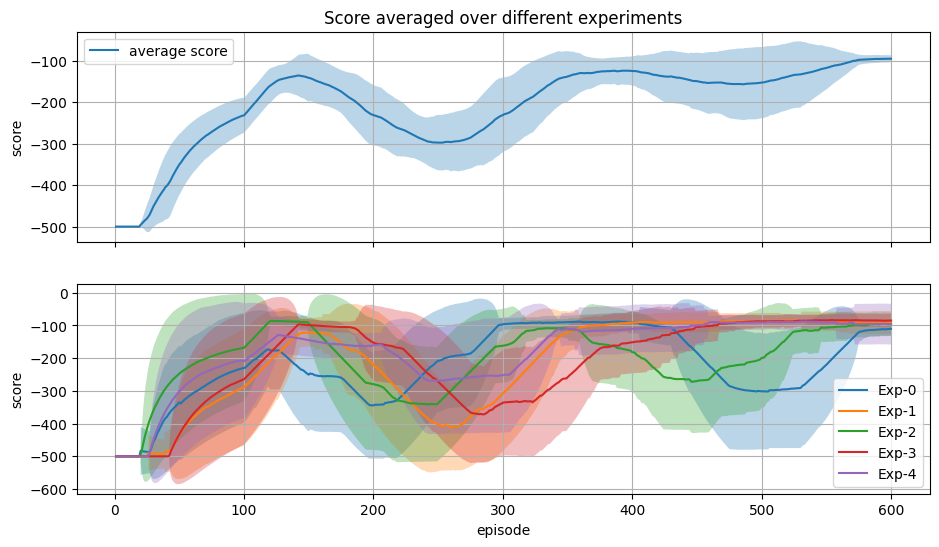

In [8]:
results_data_dict["Q-Learning"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

We see that Q-Learning results in a set of learning curves with a lot of variance, and an overall mean score of about -100, which is not bad. 

## Double Q-Learning
Below is the complete *Double Q-Learning* algorithm for the tabular case, as introduced in the [1]. We will use a neural network instead of a tabular Q-function.

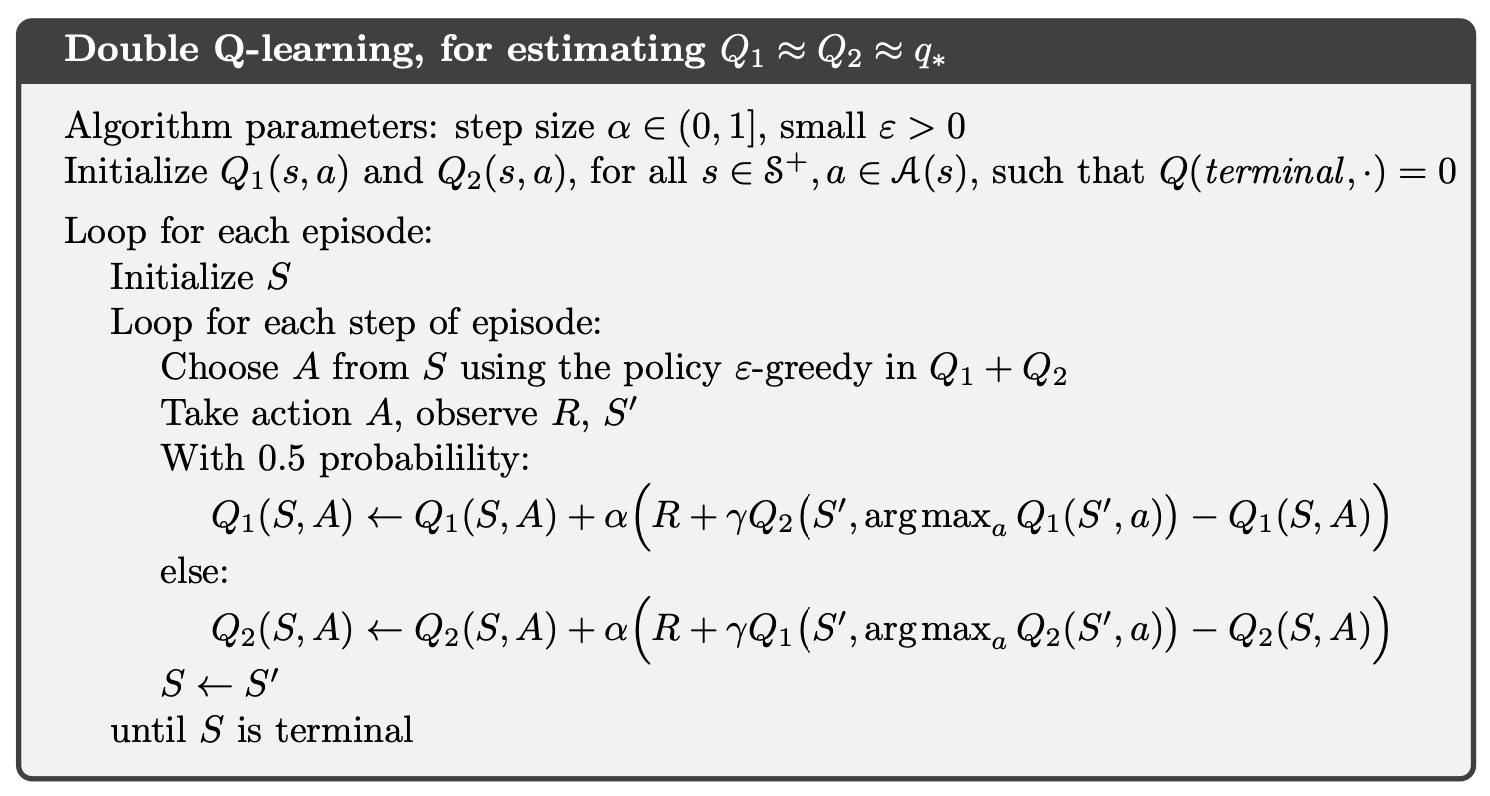

In [9]:
class OriginalDoubleQLearningAgent:
    def __init__(self, observation_dim, action_dim, n_actions, 
                 learning_rate, gamma, epsilon, epsilon_dec, epsilon_min, 
                 memory_size):
        super(OriginalDoubleQLearningAgent, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.memory_size = memory_size
        self.learning_steps = 0
        
        # initialize the q networks
        self.q1 = QNetwork(observation_dim, n_actions, learning_rate)
        self.q2 = QNetwork(observation_dim, n_actions, learning_rate)
        
        # initialize a replay buffer
        self.replay_buffer = ReplayBuffer(memory_size, observation_dim)
        self.replay_buffer.reset()
        
    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(low=0, high=self.n_actions, size=1)[0]
        else:
            observation = T.from_numpy(observation).float()
            
            # compute the q values for each q function
            q1_values = self.q1(observation.to(self.q1.device))
            q2_values = self.q2(observation.to(self.q2.device))
            
            # estimate the next action as the argmax of the sum
            q_values = q1_values + q2_values
            action = T.argmax(q_values).item()
        return action
                
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
        
    def store_transition(self, observation, action, reward, next_observation, terminated):
        self.replay_buffer.store_transition(observation, action, reward, next_observation, terminated)
        
    def load_batch(self, batch_size=1):
        return self.replay_buffer.load_transition(batch_size) 
        
    
    def learn(self, batch_size=1):
        self.learning_steps += 1
        if self.learning_steps <= batch_size:
            return
        
        # load batch from buffer
        observation, action, reward, next_observation, terminated = self.load_batch(batch_size)
        
        # choose randomly between the two networks, which is the target network
        if np.random.randint(2):
            q = self.q1
            q_ = self.q2
        else:
            q = self.q2
            q_ = self.q1
            
        # send the transition to the device
        observation = T.from_numpy(observation).float().to(q.device)
        action = T.from_numpy(action).int().view(-1).to(q.device)
        reward = T.tensor(reward).float().view(-1).to(q.device)
        next_observation = T.from_numpy(next_observation).float().to(q.device)
        terminated = T.from_numpy(terminated).bool().view(-1).to(q.device)
        
        # compute the q_values using q1 and q2
        indices = T.arange(batch_size)
        
        # compute the q value of (s_{t}, a_{t})
        q_value = q(observation)[indices, action]
        
        # compute the best action according to q
        next_action = T.argmax(q(next_observation), dim=1)
        
        # estimate its value according to q_
        next_q__value = q_(next_observation)[indices, next_action]
        
        # set terminal state values to zero by hand
        next_q__value[terminated] = 0.0  
        
        # compute the target
        target = (reward + self.gamma * next_q__value).to(q.device)
        
        # compute the loss and backpropagate
        q.optimizer.zero_grad()
        q_loss = F.mse_loss(q_value, target)
        q_loss.backward()
        q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()
    

In [10]:
env = gym.make('Acrobot-v1')
scores = []
avg_scores = []
std_scores = []
epsilons = []

N_EXPERIMENTS = 5
N_EPISODES = 600
MAX_STEPS = 600
GAMMA = 0.99
LR = 5e-5
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.1)
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = 1
N_ACTIONS = env.action_space.n
MEMORY_SIZE = 100000
BATCH_SIZE = 8

# run the experiments
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    epsilons.append([])
    
    # init the agent
    agent = OriginalDoubleQLearningAgent(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, 
                                         n_actions=N_ACTIONS, learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, 
                                         epsilon_dec=EPSILON_DEC, epsilon_min=EPSILON_MIN, memory_size=MEMORY_SIZE)
    # run the episodes for each experiment
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        score = 0
        step = 0
        done = False

        while not done:
            step += 1
            epsilons[ex_i].append(agent.epsilon)
            action = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # store transition
            agent.store_transition(observation, action, reward, next_observation, terminated)
            
            # train the agent
            agent.learn(batch_size=BATCH_SIZE)
            
            # set next states to current states
            observation = next_observation
            
            # check for end of episode
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f}' + \
              f'| Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

reset buffer...
| Experiment:    1 | Episode:    0 | Score: -236.000| Avg score: -236.000 |
| Experiment:    1 | Episode:    1 | Score: -500.000| Avg score: -368.000 |
| Experiment:    1 | Episode:    2 | Score: -500.000| Avg score: -412.000 |
| Experiment:    1 | Episode:    3 | Score: -257.000| Avg score: -373.250 |
| Experiment:    1 | Episode:    4 | Score: -500.000| Avg score: -398.600 |
| Experiment:    1 | Episode:    5 | Score: -205.000| Avg score: -366.330 |
| Experiment:    1 | Episode:    6 | Score: -154.000| Avg score: -336.000 |
| Experiment:    1 | Episode:    7 | Score: -339.000| Avg score: -336.380 |
| Experiment:    1 | Episode:    8 | Score: -320.000| Avg score: -334.560 |
| Experiment:    1 | Episode:    9 | Score: -172.000| Avg score: -318.300 |
| Experiment:    1 | Episode:   10 | Score: -117.000| Avg score: -300.000 |
| Experiment:    1 | Episode:   11 | Score: -212.000| Avg score: -292.670 |
| Experiment:    1 | Episode:   12 | Score: -147.000| Avg score: -281.46

| Experiment:    1 | Episode:  109 | Score: -171.000| Avg score: -155.000 |
| Experiment:    1 | Episode:  110 | Score: -163.000| Avg score: -155.460 |
| Experiment:    1 | Episode:  111 | Score: -133.000| Avg score: -154.670 |
| Experiment:    1 | Episode:  112 | Score: -125.000| Avg score: -154.450 |
| Experiment:    1 | Episode:  113 | Score: -151.000| Avg score: -154.440 |
| Experiment:    1 | Episode:  114 | Score: -158.000| Avg score: -154.530 |
| Experiment:    1 | Episode:  115 | Score: -112.000| Avg score: -153.940 |
| Experiment:    1 | Episode:  116 | Score: -141.000| Avg score: -153.930 |
| Experiment:    1 | Episode:  117 | Score: -125.000| Avg score: -153.430 |
| Experiment:    1 | Episode:  118 | Score: -170.000| Avg score: -153.540 |
| Experiment:    1 | Episode:  119 | Score: -146.000| Avg score: -153.460 |
| Experiment:    1 | Episode:  120 | Score: -158.000| Avg score: -153.630 |
| Experiment:    1 | Episode:  121 | Score: -153.000| Avg score: -152.980 |
| Experiment

| Experiment:    1 | Episode:  217 | Score: -165.000| Avg score: -166.370 |
| Experiment:    1 | Episode:  218 | Score: -162.000| Avg score: -166.290 |
| Experiment:    1 | Episode:  219 | Score: -198.000| Avg score: -166.810 |
| Experiment:    1 | Episode:  220 | Score: -201.000| Avg score: -167.240 |
| Experiment:    1 | Episode:  221 | Score: -152.000| Avg score: -167.230 |
| Experiment:    1 | Episode:  222 | Score: -169.000| Avg score: -167.410 |
| Experiment:    1 | Episode:  223 | Score: -154.000| Avg score: -167.320 |
| Experiment:    1 | Episode:  224 | Score: -177.000| Avg score: -167.510 |
| Experiment:    1 | Episode:  225 | Score: -163.000| Avg score: -167.450 |
| Experiment:    1 | Episode:  226 | Score: -159.000| Avg score: -167.640 |
| Experiment:    1 | Episode:  227 | Score: -178.000| Avg score: -168.140 |
| Experiment:    1 | Episode:  228 | Score: -192.000| Avg score: -168.800 |
| Experiment:    1 | Episode:  229 | Score: -195.000| Avg score: -169.310 |
| Experiment

| Experiment:    1 | Episode:  326 | Score: -282.000| Avg score: -178.770 |
| Experiment:    1 | Episode:  327 | Score: -298.000| Avg score: -179.970 |
| Experiment:    1 | Episode:  328 | Score: -155.000| Avg score: -179.600 |
| Experiment:    1 | Episode:  329 | Score: -182.000| Avg score: -179.470 |
| Experiment:    1 | Episode:  330 | Score: -171.000| Avg score: -179.350 |
| Experiment:    1 | Episode:  331 | Score: -147.000| Avg score: -179.080 |
| Experiment:    1 | Episode:  332 | Score: -144.000| Avg score: -178.290 |
| Experiment:    1 | Episode:  333 | Score: -158.000| Avg score: -178.030 |
| Experiment:    1 | Episode:  334 | Score: -186.000| Avg score: -178.190 |
| Experiment:    1 | Episode:  335 | Score: -133.000| Avg score: -178.190 |
| Experiment:    1 | Episode:  336 | Score: -123.000| Avg score: -177.880 |
| Experiment:    1 | Episode:  337 | Score: -133.000| Avg score: -177.600 |
| Experiment:    1 | Episode:  338 | Score: -166.000| Avg score: -177.620 |
| Experiment

| Experiment:    1 | Episode:  436 | Score: -138.000| Avg score: -159.070 |
| Experiment:    1 | Episode:  437 | Score: -156.000| Avg score: -159.300 |
| Experiment:    1 | Episode:  438 | Score: -127.000| Avg score: -158.910 |
| Experiment:    1 | Episode:  439 | Score: -137.000| Avg score: -158.400 |
| Experiment:    1 | Episode:  440 | Score: -153.000| Avg score: -158.300 |
| Experiment:    1 | Episode:  441 | Score: -208.000| Avg score: -158.880 |
| Experiment:    1 | Episode:  442 | Score: -105.000| Avg score: -158.340 |
| Experiment:    1 | Episode:  443 | Score: -127.000| Avg score: -156.990 |
| Experiment:    1 | Episode:  444 | Score: -139.000| Avg score: -156.780 |
| Experiment:    1 | Episode:  445 | Score: -162.000| Avg score: -155.130 |
| Experiment:    1 | Episode:  446 | Score: -96.000| Avg score: -154.440 |
| Experiment:    1 | Episode:  447 | Score: -121.000| Avg score: -153.890 |
| Experiment:    1 | Episode:  448 | Score: -120.000| Avg score: -150.090 |
| Experiment:

| Experiment:    1 | Episode:  544 | Score: -105.000| Avg score: -132.010 |
| Experiment:    1 | Episode:  545 | Score: -177.000| Avg score: -132.160 |
| Experiment:    1 | Episode:  546 | Score: -111.000| Avg score: -132.310 |
| Experiment:    1 | Episode:  547 | Score: -129.000| Avg score: -132.390 |
| Experiment:    1 | Episode:  548 | Score: -93.000| Avg score: -132.120 |
| Experiment:    1 | Episode:  549 | Score: -106.000| Avg score: -131.870 |
| Experiment:    1 | Episode:  550 | Score: -98.000| Avg score: -131.520 |
| Experiment:    1 | Episode:  551 | Score: -231.000| Avg score: -132.510 |
| Experiment:    1 | Episode:  552 | Score: -103.000| Avg score: -132.380 |
| Experiment:    1 | Episode:  553 | Score: -116.000| Avg score: -132.420 |
| Experiment:    1 | Episode:  554 | Score: -110.000| Avg score: -131.350 |
| Experiment:    1 | Episode:  555 | Score: -164.000| Avg score: -131.780 |
| Experiment:    1 | Episode:  556 | Score: -139.000| Avg score: -132.130 |
| Experiment: 

| Experiment:    2 | Episode:   53 | Score: -64.000| Avg score: -134.300 |
| Experiment:    2 | Episode:   54 | Score: -76.000| Avg score: -133.240 |
| Experiment:    2 | Episode:   55 | Score: -95.000| Avg score: -132.550 |
| Experiment:    2 | Episode:   56 | Score: -74.000| Avg score: -131.530 |
| Experiment:    2 | Episode:   57 | Score: -78.000| Avg score: -130.600 |
| Experiment:    2 | Episode:   58 | Score: -101.000| Avg score: -130.100 |
| Experiment:    2 | Episode:   59 | Score: -104.000| Avg score: -129.670 |
| Experiment:    2 | Episode:   60 | Score: -72.000| Avg score: -128.720 |
| Experiment:    2 | Episode:   61 | Score: -72.000| Avg score: -127.810 |
| Experiment:    2 | Episode:   62 | Score: -212.000| Avg score: -129.140 |
| Experiment:    2 | Episode:   63 | Score: -77.000| Avg score: -128.330 |
| Experiment:    2 | Episode:   64 | Score: -73.000| Avg score: -127.480 |
| Experiment:    2 | Episode:   65 | Score: -82.000| Avg score: -126.790 |
| Experiment:    2 | E

| Experiment:    2 | Episode:  163 | Score: -75.000| Avg score: -88.250 |
| Experiment:    2 | Episode:  164 | Score: -108.000| Avg score: -88.600 |
| Experiment:    2 | Episode:  165 | Score: -81.000| Avg score: -88.590 |
| Experiment:    2 | Episode:  166 | Score: -91.000| Avg score: -88.660 |
| Experiment:    2 | Episode:  167 | Score: -150.000| Avg score: -88.810 |
| Experiment:    2 | Episode:  168 | Score: -74.000| Avg score: -88.320 |
| Experiment:    2 | Episode:  169 | Score: -93.000| Avg score: -88.390 |
| Experiment:    2 | Episode:  170 | Score: -84.000| Avg score: -88.540 |
| Experiment:    2 | Episode:  171 | Score: -108.000| Avg score: -88.820 |
| Experiment:    2 | Episode:  172 | Score: -75.000| Avg score: -88.690 |
| Experiment:    2 | Episode:  173 | Score: -96.000| Avg score: -88.790 |
| Experiment:    2 | Episode:  174 | Score: -83.000| Avg score: -88.690 |
| Experiment:    2 | Episode:  175 | Score: -86.000| Avg score: -88.770 |
| Experiment:    2 | Episode:  176 

| Experiment:    2 | Episode:  276 | Score: -111.000| Avg score: -100.170 |
| Experiment:    2 | Episode:  277 | Score: -86.000| Avg score: -100.130 |
| Experiment:    2 | Episode:  278 | Score: -81.000| Avg score: -100.110 |
| Experiment:    2 | Episode:  279 | Score: -74.000| Avg score: -100.010 |
| Experiment:    2 | Episode:  280 | Score: -79.000| Avg score: -99.460 |
| Experiment:    2 | Episode:  281 | Score: -81.000| Avg score: -99.380 |
| Experiment:    2 | Episode:  282 | Score: -116.000| Avg score: -99.560 |
| Experiment:    2 | Episode:  283 | Score: -79.000| Avg score: -99.360 |
| Experiment:    2 | Episode:  284 | Score: -74.000| Avg score: -98.050 |
| Experiment:    2 | Episode:  285 | Score: -109.000| Avg score: -97.660 |
| Experiment:    2 | Episode:  286 | Score: -168.000| Avg score: -98.270 |
| Experiment:    2 | Episode:  287 | Score: -84.000| Avg score: -98.340 |
| Experiment:    2 | Episode:  288 | Score: -74.000| Avg score: -98.010 |
| Experiment:    2 | Episode: 

| Experiment:    2 | Episode:  387 | Score: -94.000| Avg score: -102.980 |
| Experiment:    2 | Episode:  388 | Score: -81.000| Avg score: -103.050 |
| Experiment:    2 | Episode:  389 | Score: -83.000| Avg score: -102.980 |
| Experiment:    2 | Episode:  390 | Score: -88.000| Avg score: -102.240 |
| Experiment:    2 | Episode:  391 | Score: -83.000| Avg score: -102.140 |
| Experiment:    2 | Episode:  392 | Score: -82.000| Avg score: -102.010 |
| Experiment:    2 | Episode:  393 | Score: -85.000| Avg score: -101.770 |
| Experiment:    2 | Episode:  394 | Score: -82.000| Avg score: -101.720 |
| Experiment:    2 | Episode:  395 | Score: -96.000| Avg score: -101.850 |
| Experiment:    2 | Episode:  396 | Score: -74.000| Avg score: -100.820 |
| Experiment:    2 | Episode:  397 | Score: -74.000| Avg score: -100.500 |
| Experiment:    2 | Episode:  398 | Score: -99.000| Avg score: -100.510 |
| Experiment:    2 | Episode:  399 | Score: -98.000| Avg score: -100.550 |
| Experiment:    2 | Epis

| Experiment:    2 | Episode:  498 | Score: -78.000| Avg score: -93.500 |
| Experiment:    2 | Episode:  499 | Score: -86.000| Avg score: -93.380 |
| Experiment:    2 | Episode:  500 | Score: -73.000| Avg score: -93.360 |
| Experiment:    2 | Episode:  501 | Score: -73.000| Avg score: -93.240 |
| Experiment:    2 | Episode:  502 | Score: -72.000| Avg score: -93.140 |
| Experiment:    2 | Episode:  503 | Score: -79.000| Avg score: -92.480 |
| Experiment:    2 | Episode:  504 | Score: -179.000| Avg score: -93.300 |
| Experiment:    2 | Episode:  505 | Score: -108.000| Avg score: -93.540 |
| Experiment:    2 | Episode:  506 | Score: -114.000| Avg score: -93.880 |
| Experiment:    2 | Episode:  507 | Score: -78.000| Avg score: -93.690 |
| Experiment:    2 | Episode:  508 | Score: -90.000| Avg score: -93.740 |
| Experiment:    2 | Episode:  509 | Score: -79.000| Avg score: -93.580 |
| Experiment:    2 | Episode:  510 | Score: -96.000| Avg score: -93.740 |
| Experiment:    2 | Episode:  511 

| Experiment:    3 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   12 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   13 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   14 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   15 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   16 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   17 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   18 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   19 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   20 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    3 | Episode:  116 | Score: -210.000| Avg score: -347.550 |
| Experiment:    3 | Episode:  117 | Score: -153.000| Avg score: -344.080 |
| Experiment:    3 | Episode:  118 | Score: -124.000| Avg score: -340.320 |
| Experiment:    3 | Episode:  119 | Score: -175.000| Avg score: -337.070 |
| Experiment:    3 | Episode:  120 | Score: -153.000| Avg score: -333.600 |
| Experiment:    3 | Episode:  121 | Score: -162.000| Avg score: -330.220 |
| Experiment:    3 | Episode:  122 | Score: -146.000| Avg score: -326.680 |
| Experiment:    3 | Episode:  123 | Score: -186.000| Avg score: -323.540 |
| Experiment:    3 | Episode:  124 | Score: -139.000| Avg score: -319.930 |
| Experiment:    3 | Episode:  125 | Score: -160.000| Avg score: -316.530 |
| Experiment:    3 | Episode:  126 | Score: -126.000| Avg score: -312.790 |
| Experiment:    3 | Episode:  127 | Score: -155.000| Avg score: -309.340 |
| Experiment:    3 | Episode:  128 | Score: -223.000| Avg score: -306.570 |
| Experiment

| Experiment:    3 | Episode:  224 | Score: -125.000| Avg score: -161.180 |
| Experiment:    3 | Episode:  225 | Score: -118.000| Avg score: -160.760 |
| Experiment:    3 | Episode:  226 | Score: -118.000| Avg score: -160.680 |
| Experiment:    3 | Episode:  227 | Score: -127.000| Avg score: -160.400 |
| Experiment:    3 | Episode:  228 | Score: -143.000| Avg score: -159.600 |
| Experiment:    3 | Episode:  229 | Score: -254.000| Avg score: -160.930 |
| Experiment:    3 | Episode:  230 | Score: -116.000| Avg score: -160.770 |
| Experiment:    3 | Episode:  231 | Score: -202.000| Avg score: -159.280 |
| Experiment:    3 | Episode:  232 | Score: -223.000| Avg score: -160.220 |
| Experiment:    3 | Episode:  233 | Score: -158.000| Avg score: -159.900 |
| Experiment:    3 | Episode:  234 | Score: -116.000| Avg score: -159.720 |
| Experiment:    3 | Episode:  235 | Score: -246.000| Avg score: -160.660 |
| Experiment:    3 | Episode:  236 | Score: -164.000| Avg score: -160.810 |
| Experiment

| Experiment:    3 | Episode:  333 | Score: -192.000| Avg score: -164.970 |
| Experiment:    3 | Episode:  334 | Score: -228.000| Avg score: -166.090 |
| Experiment:    3 | Episode:  335 | Score: -228.000| Avg score: -165.910 |
| Experiment:    3 | Episode:  336 | Score: -500.000| Avg score: -169.270 |
| Experiment:    3 | Episode:  337 | Score: -263.000| Avg score: -166.900 |
| Experiment:    3 | Episode:  338 | Score: -182.000| Avg score: -167.390 |
| Experiment:    3 | Episode:  339 | Score: -282.000| Avg score: -169.060 |
| Experiment:    3 | Episode:  340 | Score: -267.000| Avg score: -169.550 |
| Experiment:    3 | Episode:  341 | Score: -241.000| Avg score: -170.440 |
| Experiment:    3 | Episode:  342 | Score: -208.000| Avg score: -170.840 |
| Experiment:    3 | Episode:  343 | Score: -168.000| Avg score: -171.120 |
| Experiment:    3 | Episode:  344 | Score: -237.000| Avg score: -172.100 |
| Experiment:    3 | Episode:  345 | Score: -170.000| Avg score: -172.660 |
| Experiment

| Experiment:    3 | Episode:  442 | Score: -165.000| Avg score: -207.230 |
| Experiment:    3 | Episode:  443 | Score: -260.000| Avg score: -208.150 |
| Experiment:    3 | Episode:  444 | Score: -139.000| Avg score: -207.170 |
| Experiment:    3 | Episode:  445 | Score: -171.000| Avg score: -207.180 |
| Experiment:    3 | Episode:  446 | Score: -171.000| Avg score: -206.370 |
| Experiment:    3 | Episode:  447 | Score: -153.000| Avg score: -205.650 |
| Experiment:    3 | Episode:  448 | Score: -129.000| Avg score: -204.760 |
| Experiment:    3 | Episode:  449 | Score: -179.000| Avg score: -204.250 |
| Experiment:    3 | Episode:  450 | Score: -139.000| Avg score: -200.640 |
| Experiment:    3 | Episode:  451 | Score: -184.000| Avg score: -198.300 |
| Experiment:    3 | Episode:  452 | Score: -131.000| Avg score: -198.060 |
| Experiment:    3 | Episode:  453 | Score: -165.000| Avg score: -196.130 |
| Experiment:    3 | Episode:  454 | Score: -144.000| Avg score: -195.240 |
| Experiment

| Experiment:    3 | Episode:  550 | Score: -500.000| Avg score: -160.100 |
| Experiment:    3 | Episode:  551 | Score: -185.000| Avg score: -160.110 |
| Experiment:    3 | Episode:  552 | Score: -183.000| Avg score: -160.630 |
| Experiment:    3 | Episode:  553 | Score: -123.000| Avg score: -160.210 |
| Experiment:    3 | Episode:  554 | Score: -162.000| Avg score: -160.390 |
| Experiment:    3 | Episode:  555 | Score: -158.000| Avg score: -159.450 |
| Experiment:    3 | Episode:  556 | Score: -140.000| Avg score: -159.300 |
| Experiment:    3 | Episode:  557 | Score: -103.000| Avg score: -158.770 |
| Experiment:    3 | Episode:  558 | Score: -167.000| Avg score: -158.900 |
| Experiment:    3 | Episode:  559 | Score: -253.000| Avg score: -159.870 |
| Experiment:    3 | Episode:  560 | Score: -129.000| Avg score: -160.050 |
| Experiment:    3 | Episode:  561 | Score: -326.000| Avg score: -161.550 |
| Experiment:    3 | Episode:  562 | Score: -141.000| Avg score: -161.280 |
| Experiment

| Experiment:    4 | Episode:   58 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   59 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   60 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   61 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   62 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   63 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   64 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   65 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   66 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   67 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   68 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   69 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   70 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    4 | Episode:  166 | Score: -239.000| Avg score: -356.590 |
| Experiment:    4 | Episode:  167 | Score: -218.000| Avg score: -353.770 |
| Experiment:    4 | Episode:  168 | Score: -298.000| Avg score: -351.750 |
| Experiment:    4 | Episode:  169 | Score: -189.000| Avg score: -348.640 |
| Experiment:    4 | Episode:  170 | Score: -264.000| Avg score: -346.280 |
| Experiment:    4 | Episode:  171 | Score: -247.000| Avg score: -343.750 |
| Experiment:    4 | Episode:  172 | Score: -216.000| Avg score: -340.910 |
| Experiment:    4 | Episode:  173 | Score: -142.000| Avg score: -337.330 |
| Experiment:    4 | Episode:  174 | Score: -170.000| Avg score: -334.030 |
| Experiment:    4 | Episode:  175 | Score: -335.000| Avg score: -332.380 |
| Experiment:    4 | Episode:  176 | Score: -500.000| Avg score: -332.380 |
| Experiment:    4 | Episode:  177 | Score: -480.000| Avg score: -332.180 |
| Experiment:    4 | Episode:  178 | Score: -402.000| Avg score: -331.200 |
| Experiment

| Experiment:    4 | Episode:  274 | Score: -151.000| Avg score: -256.140 |
| Experiment:    4 | Episode:  275 | Score: -171.000| Avg score: -254.500 |
| Experiment:    4 | Episode:  276 | Score: -260.000| Avg score: -252.100 |
| Experiment:    4 | Episode:  277 | Score: -293.000| Avg score: -250.230 |
| Experiment:    4 | Episode:  278 | Score: -231.000| Avg score: -248.520 |
| Experiment:    4 | Episode:  279 | Score: -252.000| Avg score: -249.030 |
| Experiment:    4 | Episode:  280 | Score: -285.000| Avg score: -250.420 |
| Experiment:    4 | Episode:  281 | Score: -212.000| Avg score: -249.290 |
| Experiment:    4 | Episode:  282 | Score: -412.000| Avg score: -248.410 |
| Experiment:    4 | Episode:  283 | Score: -500.000| Avg score: -250.900 |
| Experiment:    4 | Episode:  284 | Score: -389.000| Avg score: -249.790 |
| Experiment:    4 | Episode:  285 | Score: -274.000| Avg score: -249.670 |
buffer is full...
| Experiment:    4 | Episode:  286 | Score: -250.000| Avg score: -249.

| Experiment:    4 | Episode:  382 | Score: -147.000| Avg score: -272.920 |
| Experiment:    4 | Episode:  383 | Score: -175.000| Avg score: -269.670 |
| Experiment:    4 | Episode:  384 | Score: -205.000| Avg score: -267.830 |
| Experiment:    4 | Episode:  385 | Score: -156.000| Avg score: -266.650 |
| Experiment:    4 | Episode:  386 | Score: -284.000| Avg score: -266.990 |
| Experiment:    4 | Episode:  387 | Score: -175.000| Avg score: -266.650 |
| Experiment:    4 | Episode:  388 | Score: -126.000| Avg score: -265.140 |
| Experiment:    4 | Episode:  389 | Score: -205.000| Avg score: -264.920 |
| Experiment:    4 | Episode:  390 | Score: -316.000| Avg score: -266.290 |
| Experiment:    4 | Episode:  391 | Score: -247.000| Avg score: -267.120 |
| Experiment:    4 | Episode:  392 | Score: -146.000| Avg score: -266.440 |
| Experiment:    4 | Episode:  393 | Score: -123.000| Avg score: -265.430 |
| Experiment:    4 | Episode:  394 | Score: -459.000| Avg score: -265.590 |
| Experiment

| Experiment:    4 | Episode:  490 | Score: -126.000| Avg score: -170.210 |
| Experiment:    4 | Episode:  491 | Score: -234.000| Avg score: -170.080 |
| Experiment:    4 | Episode:  492 | Score: -173.000| Avg score: -170.350 |
| Experiment:    4 | Episode:  493 | Score: -124.000| Avg score: -170.360 |
| Experiment:    4 | Episode:  494 | Score: -253.000| Avg score: -168.300 |
| Experiment:    4 | Episode:  495 | Score: -99.000| Avg score: -167.520 |
| Experiment:    4 | Episode:  496 | Score: -277.000| Avg score: -168.480 |
| Experiment:    4 | Episode:  497 | Score: -181.000| Avg score: -167.510 |
| Experiment:    4 | Episode:  498 | Score: -265.000| Avg score: -168.930 |
| Experiment:    4 | Episode:  499 | Score: -157.000| Avg score: -168.960 |
| Experiment:    4 | Episode:  500 | Score: -105.000| Avg score: -168.770 |
| Experiment:    4 | Episode:  501 | Score: -119.000| Avg score: -167.500 |
| Experiment:    4 | Episode:  502 | Score: -141.000| Avg score: -167.700 |
| Experiment:

| Experiment:    4 | Episode:  598 | Score: -500.000| Avg score: -155.830 |
| Experiment:    4 | Episode:  599 | Score: -130.000| Avg score: -155.560 |
reset buffer...
| Experiment:    5 | Episode:    0 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    1 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    2 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    3 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    4 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    5 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    6 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    7 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   10 | Score: -500.000| Avg score: -500.00

| Experiment:    5 | Episode:  106 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  107 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  108 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  109 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  110 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  111 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  112 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  113 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  114 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  115 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  116 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  117 | Score: -500.000| Avg score: -456.390 |
| Experiment:    5 | Episode:  118 | Score: -500.000| Avg score: -456.390 |
| Experiment

| Experiment:    5 | Episode:  214 | Score: -500.000| Avg score: -465.860 |
buffer is full...
| Experiment:    5 | Episode:  215 | Score: -500.000| Avg score: -465.860 |
| Experiment:    5 | Episode:  216 | Score: -500.000| Avg score: -465.860 |
| Experiment:    5 | Episode:  217 | Score: -500.000| Avg score: -465.860 |
| Experiment:    5 | Episode:  218 | Score: -500.000| Avg score: -465.860 |
| Experiment:    5 | Episode:  219 | Score: -500.000| Avg score: -465.860 |
| Experiment:    5 | Episode:  220 | Score: -500.000| Avg score: -465.860 |
| Experiment:    5 | Episode:  221 | Score: -500.000| Avg score: -466.360 |
| Experiment:    5 | Episode:  222 | Score: -500.000| Avg score: -466.360 |
| Experiment:    5 | Episode:  223 | Score: -228.000| Avg score: -463.640 |
| Experiment:    5 | Episode:  224 | Score: -500.000| Avg score: -463.640 |
| Experiment:    5 | Episode:  225 | Score: -500.000| Avg score: -463.640 |
| Experiment:    5 | Episode:  226 | Score: -500.000| Avg score: -463.

| Experiment:    5 | Episode:  323 | Score: -112.000| Avg score: -366.810 |
| Experiment:    5 | Episode:  324 | Score: -126.000| Avg score: -363.070 |
| Experiment:    5 | Episode:  325 | Score: -282.000| Avg score: -360.890 |
| Experiment:    5 | Episode:  326 | Score: -233.000| Avg score: -358.220 |
| Experiment:    5 | Episode:  327 | Score: -500.000| Avg score: -358.220 |
| Experiment:    5 | Episode:  328 | Score: -258.000| Avg score: -355.800 |
| Experiment:    5 | Episode:  329 | Score: -269.000| Avg score: -355.650 |
| Experiment:    5 | Episode:  330 | Score: -263.000| Avg score: -353.280 |
| Experiment:    5 | Episode:  331 | Score: -455.000| Avg score: -352.830 |
| Experiment:    5 | Episode:  332 | Score: -193.000| Avg score: -349.760 |
| Experiment:    5 | Episode:  333 | Score: -87.000| Avg score: -345.630 |
| Experiment:    5 | Episode:  334 | Score: -126.000| Avg score: -341.890 |
| Experiment:    5 | Episode:  335 | Score: -97.000| Avg score: -337.860 |
| Experiment: 

| Experiment:    5 | Episode:  431 | Score: -500.000| Avg score: -212.540 |
| Experiment:    5 | Episode:  432 | Score: -256.000| Avg score: -213.170 |
| Experiment:    5 | Episode:  433 | Score: -314.000| Avg score: -215.440 |
| Experiment:    5 | Episode:  434 | Score: -156.000| Avg score: -215.740 |
| Experiment:    5 | Episode:  435 | Score: -425.000| Avg score: -219.020 |
| Experiment:    5 | Episode:  436 | Score: -500.000| Avg score: -222.820 |
| Experiment:    5 | Episode:  437 | Score: -147.000| Avg score: -223.120 |
| Experiment:    5 | Episode:  438 | Score: -243.000| Avg score: -223.780 |
| Experiment:    5 | Episode:  439 | Score: -240.000| Avg score: -224.760 |
| Experiment:    5 | Episode:  440 | Score: -242.000| Avg score: -226.270 |
| Experiment:    5 | Episode:  441 | Score: -115.000| Avg score: -223.200 |
| Experiment:    5 | Episode:  442 | Score: -90.000| Avg score: -222.690 |
| Experiment:    5 | Episode:  443 | Score: -313.000| Avg score: -224.810 |
| Experiment:

| Experiment:    5 | Episode:  541 | Score: -129.000| Avg score: -208.700 |
| Experiment:    5 | Episode:  542 | Score: -169.000| Avg score: -209.490 |
| Experiment:    5 | Episode:  543 | Score: -165.000| Avg score: -208.010 |
| Experiment:    5 | Episode:  544 | Score: -227.000| Avg score: -208.750 |
| Experiment:    5 | Episode:  545 | Score: -143.000| Avg score: -206.620 |
| Experiment:    5 | Episode:  546 | Score: -141.000| Avg score: -206.440 |
| Experiment:    5 | Episode:  547 | Score: -155.000| Avg score: -202.990 |
| Experiment:    5 | Episode:  548 | Score: -193.000| Avg score: -203.990 |
| Experiment:    5 | Episode:  549 | Score: -310.000| Avg score: -205.650 |
| Experiment:    5 | Episode:  550 | Score: -119.000| Avg score: -205.970 |
| Experiment:    5 | Episode:  551 | Score: -109.000| Avg score: -206.200 |
| Experiment:    5 | Episode:  552 | Score: -225.000| Avg score: -207.040 |
| Experiment:    5 | Episode:  553 | Score: -93.000| Avg score: -204.250 |
| Experiment:

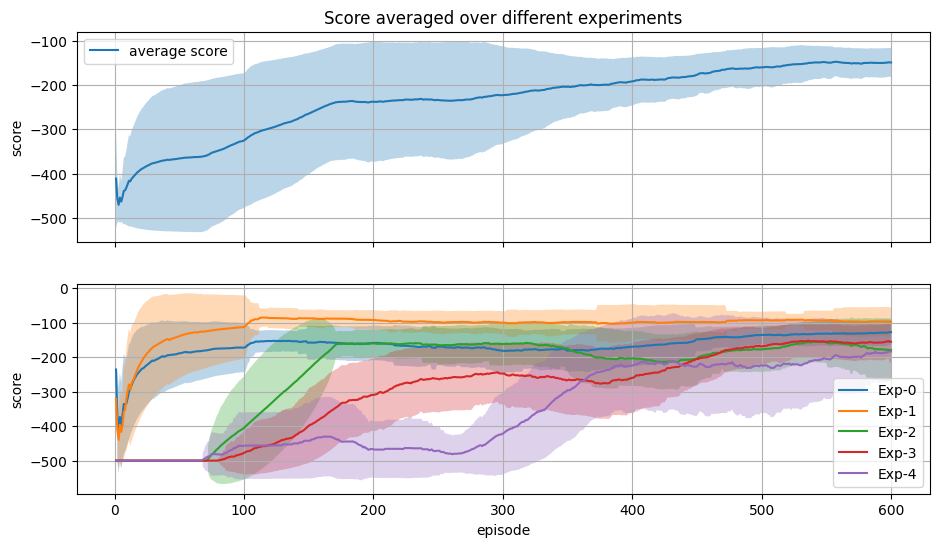

In [11]:
results_data_dict["Double Q-Learning (Original)"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

The **Original** Double Q-Learning agent results in a stable learning process per experiment, but with a large variance in learning dynamics between experiments. This could be due to lacking of hyperparameters tuning. In addition, the Double Q-Learning algorithm ends up with a mean score of -150, which is lower than the -100 of Q-Learning. However, the average learning curve is monotonic increasing, which is better than the oscillating mean curve of Q-Learning.

In [12]:
class MinDoubleQLearningAgent:
    def __init__(self, observation_dim, action_dim, n_actions, 
                 learning_rate, gamma, epsilon, epsilon_dec, epsilon_min, 
                 memory_size):
        super(MinDoubleQLearningAgent, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.memory_size = memory_size
        self.learning_steps = 0
        
        # initialize the q networks
        self.q1 = QNetwork(observation_dim, n_actions, learning_rate)
        self.q2 = QNetwork(observation_dim, n_actions, learning_rate)
        
        # initialize a replay buffer
        self.replay_buffer = ReplayBuffer(memory_size, observation_dim)
        self.replay_buffer.reset()
        
    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(low=0, high=self.n_actions, size=1)[0]
        else:
            observation = T.from_numpy(observation).float()
            
            # compute the q values for each q function
            q1_values = self.q1(observation.to(self.q1.device))
            q2_values = self.q2(observation.to(self.q2.device))
            
            # estimate the next action as the argmax of the sum
            q_values = q1_values + q2_values
            action = T.argmax(q_values).item()
        return action
                
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
        
    def store_transition(self, observation, action, reward, next_observation, terminated):
        self.replay_buffer.store_transition(observation, action, reward, next_observation, terminated)
        
    def load_batch(self, batch_size=1):
        return self.replay_buffer.load_transition(batch_size) 
        
    
    def learn(self, batch_size=1):
        self.learning_steps += 1
        if self.learning_steps <= batch_size:
            return
        
        # load batch from buffer
        observation, action, reward, next_observation, terminated = self.load_batch(batch_size)
        
        # choose randomly between the two networks, which is the target network
        if np.random.randint(2):
            q = self.q1
            q_ = self.q2
        else:
            q = self.q2
            q_ = self.q1
            
        # send the transition to the device
        observation = T.from_numpy(observation).float().to(q.device)
        action = T.from_numpy(action).int().view(-1).to(q.device)
        reward = T.tensor(reward).float().view(-1).to(q.device)
        next_observation = T.from_numpy(next_observation).float().to(q.device)
        terminated = T.from_numpy(terminated).bool().view(-1).to(q.device)
        
        # compute the q_values using q1 and q2
        indices = T.arange(batch_size)
        
        # compute the q value of (s_{t}, a_{t})
        q_value = q(observation)[indices, action]
        
        # compute the best action according to q
        next_action = T.argmax(q(next_observation), dim=1)
        
        # estimate its value according to q
        next_q_values = q(next_observation)[indices, next_action].unsqueeze(dim=1)
        
        # estimate its value according to q_
        next_q__values = q_(next_observation)[indices, next_action].unsqueeze(dim=1)
        
        # set the value as the minimum between (q, q_)
        next_q_value = T.min(T.cat([next_q_values, next_q__values], dim=1), dim=1)[0]
        
        # set terminal state values to zero by hand
        next_q_value[terminated] = 0.0  
        
        # compute the target
        target = (reward + self.gamma * next_q_value).to(q.device)
        
        # compute the loss and backpropagate
        q.optimizer.zero_grad()
        q_loss = F.mse_loss(q_value, target)
        q_loss.backward()
        q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()
    

Now we run a few experiments with the Double Q-Learning which uses the **Minimum** type update-rule

In [13]:
env = gym.make('Acrobot-v1')
scores = []
avg_scores = []
std_scores = []
epsilons = []

N_EXPERIMENTS = 5
N_EPISODES = 600
MAX_STEPS = 600
GAMMA = 0.99
LR = 5e-5
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.1)
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = 1
N_ACTIONS = env.action_space.n
MEMORY_SIZE = 100000
BATCH_SIZE = 8

# run the experiments
for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    epsilons.append([])
    
    # init the agent
    agent = MinDoubleQLearningAgent(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, 
                                    n_actions=N_ACTIONS, learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, 
                                    epsilon_dec=EPSILON_DEC, epsilon_min=EPSILON_MIN, memory_size=MEMORY_SIZE)
    # run the episodes for each experiment
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        score = 0
        step = 0
        done = False

        while not done:
            step += 1
            epsilons[ex_i].append(agent.epsilon)
            action = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # store transition
            agent.store_transition(observation, action, reward, next_observation, terminated)
            
            # train the agent
            agent.learn(batch_size=BATCH_SIZE)
            
            # set next states to current states
            observation = next_observation
            
            # check for end of episode
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f}' + \
              f'| Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

reset buffer...
| Experiment:    1 | Episode:    0 | Score: -467.000| Avg score: -467.000 |
| Experiment:    1 | Episode:    1 | Score: -500.000| Avg score: -483.500 |
| Experiment:    1 | Episode:    2 | Score: -500.000| Avg score: -489.000 |
| Experiment:    1 | Episode:    3 | Score: -500.000| Avg score: -491.750 |
| Experiment:    1 | Episode:    4 | Score: -500.000| Avg score: -493.400 |
| Experiment:    1 | Episode:    5 | Score: -500.000| Avg score: -494.500 |
| Experiment:    1 | Episode:    6 | Score: -500.000| Avg score: -495.290 |
| Experiment:    1 | Episode:    7 | Score: -500.000| Avg score: -495.880 |
| Experiment:    1 | Episode:    8 | Score: -500.000| Avg score: -496.330 |
| Experiment:    1 | Episode:    9 | Score: -500.000| Avg score: -496.700 |
| Experiment:    1 | Episode:   10 | Score: -500.000| Avg score: -497.000 |
| Experiment:    1 | Episode:   11 | Score: -500.000| Avg score: -497.250 |
| Experiment:    1 | Episode:   12 | Score: -500.000| Avg score: -497.46

| Experiment:    1 | Episode:  108 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  109 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  110 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  111 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  112 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  113 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  114 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  115 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  116 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  117 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  118 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  119 | Score: -500.000| Avg score: -493.360 |
| Experiment:    1 | Episode:  120 | Score: -500.000| Avg score: -493.800 |
| Experiment

| Experiment:    1 | Episode:  216 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  217 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  218 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  219 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  220 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  221 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  222 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  223 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  224 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  225 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  226 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  227 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  228 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    1 | Episode:  324 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  325 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  326 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  327 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  328 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  329 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  330 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  331 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  332 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  333 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  334 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  335 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  336 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    1 | Episode:  432 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  433 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  434 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  435 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  436 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  437 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  438 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  439 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  440 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  441 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  442 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  443 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  444 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    1 | Episode:  540 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  541 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  542 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  543 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  544 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  545 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  546 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  547 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  548 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  549 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  550 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  551 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  552 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:   48 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   49 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   50 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   51 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   52 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   53 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   54 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   55 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   56 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   57 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   58 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   59 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   60 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  156 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  157 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  158 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  159 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  160 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  161 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  162 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  163 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  164 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  165 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  166 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  167 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  168 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  264 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  265 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  266 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  267 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  268 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  269 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  270 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  271 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  272 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  273 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  274 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  275 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  276 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  372 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  373 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  374 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  375 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  376 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  377 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  378 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  379 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  380 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  381 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  382 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  383 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  384 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  480 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  481 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  482 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  483 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  484 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  485 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  486 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  487 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  488 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  489 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  490 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  491 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  492 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  588 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  589 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  590 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  591 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  592 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  593 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  594 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  595 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  596 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  597 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  598 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  599 | Score: -500.000| Avg score: -500.000 |
reset buffer...
| Experiment:    3 | Episode:    0 | Score: -500.000| Avg score: -500.00

| Experiment:    3 | Episode:   97 | Score: -151.000| Avg score: -184.630 |
| Experiment:    3 | Episode:   98 | Score: -119.000| Avg score: -183.970 |
| Experiment:    3 | Episode:   99 | Score: -152.000| Avg score: -183.650 |
| Experiment:    3 | Episode:  100 | Score: -239.000| Avg score: -181.040 |
| Experiment:    3 | Episode:  101 | Score: -227.000| Avg score: -181.780 |
| Experiment:    3 | Episode:  102 | Score: -169.000| Avg score: -178.470 |
| Experiment:    3 | Episode:  103 | Score: -181.000| Avg score: -175.280 |
| Experiment:    3 | Episode:  104 | Score: -163.000| Avg score: -171.910 |
| Experiment:    3 | Episode:  105 | Score: -170.000| Avg score: -168.610 |
| Experiment:    3 | Episode:  106 | Score: -209.000| Avg score: -167.950 |
| Experiment:    3 | Episode:  107 | Score: -278.000| Avg score: -169.310 |
| Experiment:    3 | Episode:  108 | Score: -139.000| Avg score: -169.280 |
| Experiment:    3 | Episode:  109 | Score: -154.000| Avg score: -169.510 |
| Experiment

| Experiment:    3 | Episode:  206 | Score: -404.000| Avg score: -183.660 |
| Experiment:    3 | Episode:  207 | Score: -144.000| Avg score: -182.320 |
| Experiment:    3 | Episode:  208 | Score: -141.000| Avg score: -182.340 |
| Experiment:    3 | Episode:  209 | Score: -166.000| Avg score: -182.460 |
| Experiment:    3 | Episode:  210 | Score: -163.000| Avg score: -182.610 |
| Experiment:    3 | Episode:  211 | Score: -142.000| Avg score: -182.290 |
| Experiment:    3 | Episode:  212 | Score: -133.000| Avg score: -181.860 |
| Experiment:    3 | Episode:  213 | Score: -298.000| Avg score: -181.870 |
| Experiment:    3 | Episode:  214 | Score: -198.000| Avg score: -182.290 |
| Experiment:    3 | Episode:  215 | Score: -165.000| Avg score: -182.360 |
| Experiment:    3 | Episode:  216 | Score: -137.000| Avg score: -181.900 |
| Experiment:    3 | Episode:  217 | Score: -146.000| Avg score: -181.610 |
| Experiment:    3 | Episode:  218 | Score: -178.000| Avg score: -181.710 |
| Experiment

| Experiment:    3 | Episode:  315 | Score: -137.000| Avg score: -167.580 |
| Experiment:    3 | Episode:  316 | Score: -133.000| Avg score: -167.540 |
| Experiment:    3 | Episode:  317 | Score: -170.000| Avg score: -167.780 |
| Experiment:    3 | Episode:  318 | Score: -112.000| Avg score: -167.120 |
| Experiment:    3 | Episode:  319 | Score: -188.000| Avg score: -166.130 |
| Experiment:    3 | Episode:  320 | Score: -277.000| Avg score: -166.060 |
| Experiment:    3 | Episode:  321 | Score: -132.000| Avg score: -165.460 |
| Experiment:    3 | Episode:  322 | Score: -108.000| Avg score: -164.970 |
| Experiment:    3 | Episode:  323 | Score: -165.000| Avg score: -164.800 |
| Experiment:    3 | Episode:  324 | Score: -156.000| Avg score: -164.570 |
| Experiment:    3 | Episode:  325 | Score: -145.000| Avg score: -164.320 |
| Experiment:    3 | Episode:  326 | Score: -186.000| Avg score: -165.050 |
| Experiment:    3 | Episode:  327 | Score: -179.000| Avg score: -164.200 |
| Experiment

| Experiment:    3 | Episode:  423 | Score: -137.000| Avg score: -168.140 |
| Experiment:    3 | Episode:  424 | Score: -308.000| Avg score: -169.660 |
| Experiment:    3 | Episode:  425 | Score: -158.000| Avg score: -169.790 |
| Experiment:    3 | Episode:  426 | Score: -170.000| Avg score: -169.630 |
| Experiment:    3 | Episode:  427 | Score: -167.000| Avg score: -169.510 |
| Experiment:    3 | Episode:  428 | Score: -191.000| Avg score: -169.510 |
| Experiment:    3 | Episode:  429 | Score: -161.000| Avg score: -169.860 |
| Experiment:    3 | Episode:  430 | Score: -187.000| Avg score: -169.990 |
| Experiment:    3 | Episode:  431 | Score: -163.000| Avg score: -169.970 |
| Experiment:    3 | Episode:  432 | Score: -170.000| Avg score: -170.110 |
| Experiment:    3 | Episode:  433 | Score: -132.000| Avg score: -170.010 |
| Experiment:    3 | Episode:  434 | Score: -218.000| Avg score: -170.730 |
| Experiment:    3 | Episode:  435 | Score: -120.000| Avg score: -170.340 |
| Experiment

| Experiment:    3 | Episode:  531 | Score: -148.000| Avg score: -153.920 |
| Experiment:    3 | Episode:  532 | Score: -117.000| Avg score: -153.390 |
| Experiment:    3 | Episode:  533 | Score: -137.000| Avg score: -153.440 |
| Experiment:    3 | Episode:  534 | Score: -159.000| Avg score: -152.850 |
| Experiment:    3 | Episode:  535 | Score: -141.000| Avg score: -153.060 |
| Experiment:    3 | Episode:  536 | Score: -143.000| Avg score: -152.950 |
| Experiment:    3 | Episode:  537 | Score: -151.000| Avg score: -152.820 |
| Experiment:    3 | Episode:  538 | Score: -144.000| Avg score: -152.190 |
| Experiment:    3 | Episode:  539 | Score: -140.000| Avg score: -151.480 |
| Experiment:    3 | Episode:  540 | Score: -110.000| Avg score: -151.410 |
| Experiment:    3 | Episode:  541 | Score: -144.000| Avg score: -151.200 |
| Experiment:    3 | Episode:  542 | Score: -117.000| Avg score: -151.260 |
| Experiment:    3 | Episode:  543 | Score: -146.000| Avg score: -151.400 |
| Experiment

| Experiment:    4 | Episode:   39 | Score: -379.000| Avg score: -487.320 |
| Experiment:    4 | Episode:   40 | Score: -229.000| Avg score: -481.020 |
| Experiment:    4 | Episode:   41 | Score: -388.000| Avg score: -478.810 |
| Experiment:    4 | Episode:   42 | Score: -437.000| Avg score: -477.840 |
| Experiment:    4 | Episode:   43 | Score: -473.000| Avg score: -477.730 |
| Experiment:    4 | Episode:   44 | Score: -498.000| Avg score: -478.180 |
| Experiment:    4 | Episode:   45 | Score: -500.000| Avg score: -478.650 |
| Experiment:    4 | Episode:   46 | Score: -399.000| Avg score: -476.960 |
| Experiment:    4 | Episode:   47 | Score: -329.000| Avg score: -473.880 |
| Experiment:    4 | Episode:   48 | Score: -500.000| Avg score: -474.410 |
| Experiment:    4 | Episode:   49 | Score: -500.000| Avg score: -474.920 |
| Experiment:    4 | Episode:   50 | Score: -500.000| Avg score: -475.410 |
| Experiment:    4 | Episode:   51 | Score: -452.000| Avg score: -474.960 |
| Experiment

| Experiment:    4 | Episode:  147 | Score: -500.000| Avg score: -461.300 |
| Experiment:    4 | Episode:  148 | Score: -372.000| Avg score: -460.020 |
| Experiment:    4 | Episode:  149 | Score: -401.000| Avg score: -459.030 |
| Experiment:    4 | Episode:  150 | Score: -382.000| Avg score: -457.850 |
| Experiment:    4 | Episode:  151 | Score: -500.000| Avg score: -458.330 |
| Experiment:    4 | Episode:  152 | Score: -208.000| Avg score: -455.410 |
| Experiment:    4 | Episode:  153 | Score: -500.000| Avg score: -455.410 |
| Experiment:    4 | Episode:  154 | Score: -352.000| Avg score: -456.570 |
| Experiment:    4 | Episode:  155 | Score: -500.000| Avg score: -458.160 |
| Experiment:    4 | Episode:  156 | Score: -484.000| Avg score: -459.820 |
| Experiment:    4 | Episode:  157 | Score: -500.000| Avg score: -461.040 |
| Experiment:    4 | Episode:  158 | Score: -306.000| Avg score: -459.100 |
| Experiment:    4 | Episode:  159 | Score: -500.000| Avg score: -461.300 |
| Experiment

| Experiment:    4 | Episode:  255 | Score: -266.000| Avg score: -374.080 |
| Experiment:    4 | Episode:  256 | Score: -332.000| Avg score: -372.560 |
| Experiment:    4 | Episode:  257 | Score: -366.000| Avg score: -371.220 |
| Experiment:    4 | Episode:  258 | Score: -242.000| Avg score: -370.580 |
| Experiment:    4 | Episode:  259 | Score: -243.000| Avg score: -368.010 |
| Experiment:    4 | Episode:  260 | Score: -405.000| Avg score: -367.530 |
| Experiment:    4 | Episode:  261 | Score: -366.000| Avg score: -368.680 |
| Experiment:    4 | Episode:  262 | Score: -500.000| Avg score: -368.680 |
| Experiment:    4 | Episode:  263 | Score: -462.000| Avg score: -368.300 |
| Experiment:    4 | Episode:  264 | Score: -329.000| Avg score: -366.830 |
| Experiment:    4 | Episode:  265 | Score: -405.000| Avg score: -365.880 |
| Experiment:    4 | Episode:  266 | Score: -291.000| Avg score: -363.790 |
| Experiment:    4 | Episode:  267 | Score: -500.000| Avg score: -363.790 |
| Experiment

| Experiment:    4 | Episode:  363 | Score: -315.000| Avg score: -342.770 |
| Experiment:    4 | Episode:  364 | Score: -258.000| Avg score: -342.060 |
| Experiment:    4 | Episode:  365 | Score: -178.000| Avg score: -339.790 |
| Experiment:    4 | Episode:  366 | Score: -215.000| Avg score: -339.030 |
| Experiment:    4 | Episode:  367 | Score: -274.000| Avg score: -336.770 |
| Experiment:    4 | Episode:  368 | Score: -323.000| Avg score: -336.910 |
| Experiment:    4 | Episode:  369 | Score: -183.000| Avg score: -334.750 |
| Experiment:    4 | Episode:  370 | Score: -196.000| Avg score: -331.710 |
| Experiment:    4 | Episode:  371 | Score: -500.000| Avg score: -333.680 |
| Experiment:    4 | Episode:  372 | Score: -500.000| Avg score: -336.300 |
| Experiment:    4 | Episode:  373 | Score: -500.000| Avg score: -337.420 |
| Experiment:    4 | Episode:  374 | Score: -500.000| Avg score: -337.420 |
| Experiment:    4 | Episode:  375 | Score: -310.000| Avg score: -336.510 |
| Experiment

| Experiment:    4 | Episode:  471 | Score: -401.000| Avg score: -362.460 |
| Experiment:    4 | Episode:  472 | Score: -500.000| Avg score: -362.460 |
| Experiment:    4 | Episode:  473 | Score: -500.000| Avg score: -362.460 |
| Experiment:    4 | Episode:  474 | Score: -303.000| Avg score: -360.490 |
| Experiment:    4 | Episode:  475 | Score: -500.000| Avg score: -362.390 |
| Experiment:    4 | Episode:  476 | Score: -500.000| Avg score: -362.390 |
| Experiment:    4 | Episode:  477 | Score: -267.000| Avg score: -362.090 |
| Experiment:    4 | Episode:  478 | Score: -416.000| Avg score: -362.380 |
| Experiment:    4 | Episode:  479 | Score: -366.000| Avg score: -362.660 |
| Experiment:    4 | Episode:  480 | Score: -180.000| Avg score: -362.400 |
| Experiment:    4 | Episode:  481 | Score: -384.000| Avg score: -363.580 |
| Experiment:    4 | Episode:  482 | Score: -500.000| Avg score: -366.830 |
| Experiment:    4 | Episode:  483 | Score: -500.000| Avg score: -369.470 |
| Experiment

| Experiment:    4 | Episode:  579 | Score: -239.000| Avg score: -413.630 |
| Experiment:    4 | Episode:  580 | Score: -500.000| Avg score: -416.830 |
| Experiment:    4 | Episode:  581 | Score: -475.000| Avg score: -417.740 |
| Experiment:    4 | Episode:  582 | Score: -392.000| Avg score: -416.660 |
| Experiment:    4 | Episode:  583 | Score: -500.000| Avg score: -416.660 |
| Experiment:    4 | Episode:  584 | Score: -277.000| Avg score: -416.170 |
| Experiment:    4 | Episode:  585 | Score: -231.000| Avg score: -416.490 |
| Experiment:    4 | Episode:  586 | Score: -485.000| Avg score: -416.340 |
| Experiment:    4 | Episode:  587 | Score: -306.000| Avg score: -416.850 |
| Experiment:    4 | Episode:  588 | Score: -222.000| Avg score: -414.070 |
| Experiment:    4 | Episode:  589 | Score: -500.000| Avg score: -416.230 |
| Experiment:    4 | Episode:  590 | Score: -500.000| Avg score: -417.200 |
| Experiment:    4 | Episode:  591 | Score: -500.000| Avg score: -417.200 |
| Experiment

| Experiment:    5 | Episode:   87 | Score: -500.000| Avg score: -462.270 |
| Experiment:    5 | Episode:   88 | Score: -500.000| Avg score: -462.700 |
| Experiment:    5 | Episode:   89 | Score: -500.000| Avg score: -463.110 |
| Experiment:    5 | Episode:   90 | Score: -500.000| Avg score: -463.520 |
| Experiment:    5 | Episode:   91 | Score: -500.000| Avg score: -463.910 |
| Experiment:    5 | Episode:   92 | Score: -500.000| Avg score: -464.300 |
| Experiment:    5 | Episode:   93 | Score: -500.000| Avg score: -464.680 |
| Experiment:    5 | Episode:   94 | Score: -500.000| Avg score: -465.050 |
| Experiment:    5 | Episode:   95 | Score: -500.000| Avg score: -465.420 |
| Experiment:    5 | Episode:   96 | Score: -500.000| Avg score: -465.770 |
| Experiment:    5 | Episode:   97 | Score: -500.000| Avg score: -466.120 |
| Experiment:    5 | Episode:   98 | Score: -500.000| Avg score: -466.460 |
| Experiment:    5 | Episode:   99 | Score: -500.000| Avg score: -466.800 |
| Experiment

| Experiment:    5 | Episode:  195 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  196 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  197 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  198 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  199 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  200 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  201 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  202 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  203 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  204 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  205 | Score: -500.000| Avg score: -500.000 |
buffer is full...
| Experiment:    5 | Episode:  206 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  207 | Score: -500.000| Avg score: -500.

| Experiment:    5 | Episode:  303 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  304 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  305 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  306 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  307 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  308 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  309 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  310 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  311 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  312 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  313 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  314 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  315 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    5 | Episode:  411 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  412 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  413 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  414 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  415 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  416 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  417 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  418 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  419 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  420 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  421 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  422 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  423 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    5 | Episode:  519 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  520 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  521 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  522 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  523 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  524 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  525 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  526 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  527 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  528 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  529 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  530 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  531 | Score: -500.000| Avg score: -500.000 |
| Experiment

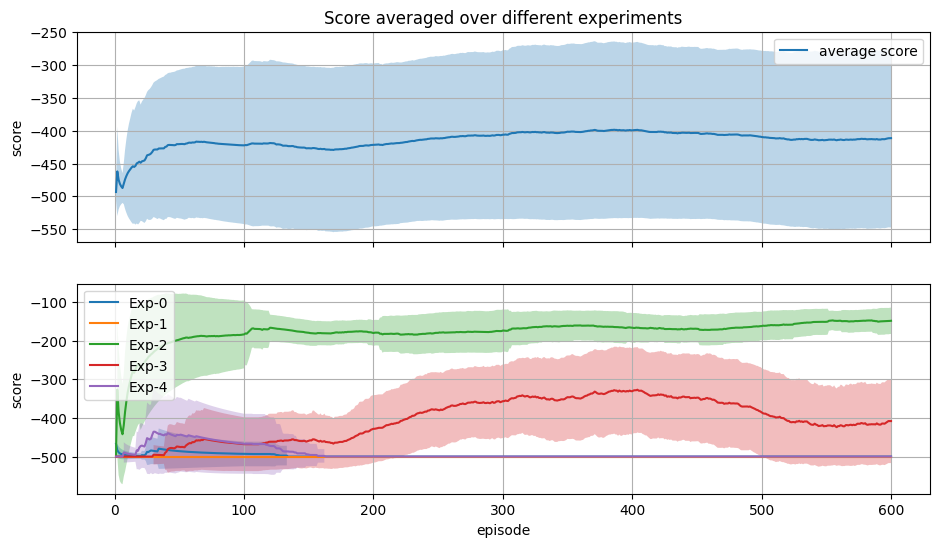

In [14]:
results_data_dict["Double Q-Learning (Minimum)"] = [avg_scores, std_scores]
plot_results(avg_scores, std_scores)

The **Minimum** Double Q-Learning agent results in some funky behavior. It seems that if the learning process is not initiated in the first 50 episodes, it does not happen at all. However, when it does learn, the algorithm results in a stable performance throughout the entire learning process.

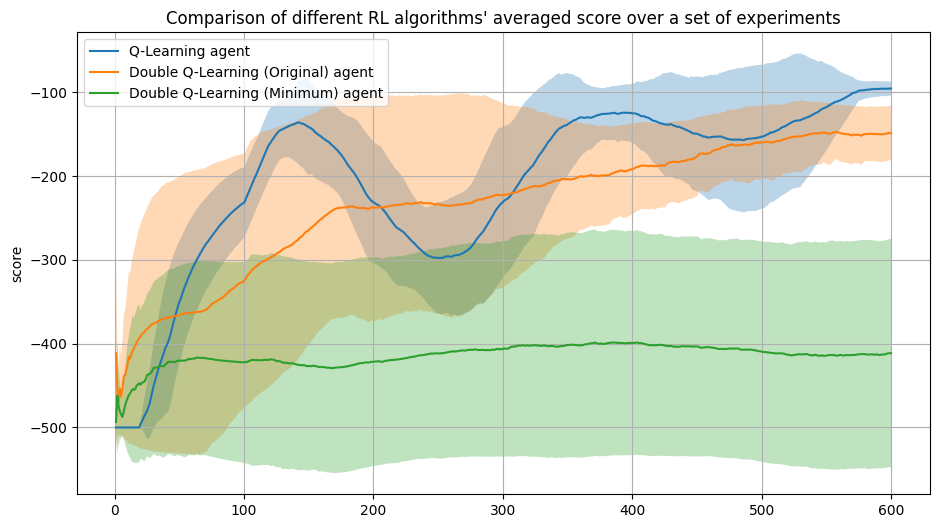

In [15]:
compare_results(results_data_dict)

## Conclusion

We have implemented two variations of the off-policy RL algorithm Double Q-Learning (with the original update-rule and a minimization-based one) and compared it with the Q-Learning algorithm. Examining the overall behavior of the three algorithms, it seems that the Q-Learning algorithm receives a better score throughout the learning process, however, with a less stable behavior and final higher variance than the original Double Q-Learning algorithm. The minimum Double Q-Learning algorithm seems to miss the target in most cases.

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com